In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats
import cellbayesassay as cba
import pickle
import itertools
import os.path
import os
import string
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
my_treatments = ['TI21', 'TI22', 'TI26']
treatment2drugname = dict(zip(my_treatments, ['Chenodiol', 'Cysteamine', 'Arundine']))

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)

fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-edited.xlsx'
datad = {}

def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)

assayd = {}

In [3]:
concentrations_LPS = concentrations.copy()
concentrations_LPS.update({
    'LPS': 1e-9,
    #'VC+L': 1e-9,
})
sheet_name = 'LPS'
assays_LPS = ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']
assayd.update({sheet_name: assays_LPS})

data = read_data(sheet_name=sheet_name, assays=assays_LPS, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_LPS)
datad[sheet_name] = data
data

Cohort  Group         IRN    TI  conc  IFN-γ  IL-10  IL-12p70  IL-1β  \
0      2.0     I1  TI 21 C1_1  TI21   1.0  0.000   6.53     48.48   0.61   
1      2.0     I1  TI 21 C1_2  TI21   1.0  0.197   8.05     61.95   1.71   
2      2.0     I1  TI 21 C1_3  TI21   1.0  0.023   6.97    143.32   0.84   
3      2.0     I1  TI 21 C1_4  TI21   1.0  0.038   6.25      4.21   0.72   
4      2.0     I1  TI 21 C1_5  TI21   1.0  0.004   5.60     23.70   0.90   
..     ...    ...         ...   ...   ...    ...    ...       ...    ...   
89     5.0  LPS 5  VC+LPS_5_2   LPS   NaN  0.019   6.87     44.88   1.52   
90     5.0  LPS 5  VC+LPS_5_3   LPS   NaN  0.000   8.26     18.15   1.42   
91     5.0  LPS 5  VC+LPS_5_4   LPS   NaN  0.000   7.52     56.22   1.44   
92     5.0  LPS 5  VC+LPS_5_5   LPS   NaN  0.012   8.55     82.39   2.39   
93     5.0  LPS 5  VC+LPS_5_6   LPS   NaN  0.000   5.75     41.86   1.61   

    IL-2   IL-4  IL-5     IL-6  KC/GRO   TNF-α  concentration  conc_log10  
0   0.50  0.000  0.00  12938.0    9.36  1734.0   1.000000e-04        -4.0  
1   1.39  0.000  0.13  13352.0    7.25  1601.0   1.000000e-04        -4.0  
2   0.46  0.026  0.65  13167.0    9.89  1333.0   1.000000e-04        -4.0  
3   0.00  0.000  0.00   8040.0    6.21  1670.0   1.000000e-04        -4.0  
4   0.00  0.000  0.00   6801.0    6.78  1272.0   1.000000e-04        -4.0  
..   ...    ...   ...      ...     ...     ...            ...         ...  
89  0.00  0.081  0.17  19845.0   13.87  1989.0   1.000000e-09        -9.0  
90  1.59  0.000  0.00  21097.0   12.33  2243.0   1.000000e-09        -9.0  
91  0.00  0.000  1.84  21231.0   25.92  2156.0   1.000000e-09        -9.0  
92  0.64  0.197  2.00  26174.0   21.33  2811.0   1.000000e-09        -9.0  
93  0.61  0.000  0.37  11942.0   14.19  1721.0   1.000000e-09        -9.0  

[72 rows x 17 columns]

In [4]:
concentrations_Ab_toxicity = concentrations.copy()
concentrations_Ab_toxicity.update({
    'LC': 1e-9,
})
sheet_name = 'Abeta Toxicity'
assays_Ab_toxicity = ['Viability [% VC]']
assayd.update({sheet_name: assays_Ab_toxicity})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_toxicity, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Ab_toxicity)
datad[sheet_name] = data
data

IRN    TI  conc  Viability [% VC]  concentration  conc_log10
0   TI 21 C1_1  TI21   1.0              76.3   1.000000e-04        -4.0
1   TI 21 C1_2  TI21   1.0              83.8   1.000000e-04        -4.0
2   TI 21 C1_3  TI21   1.0              81.7   1.000000e-04        -4.0
3   TI 21 C1_4  TI21   1.0              99.6   1.000000e-04        -4.0
4   TI 21 C1_5  TI21   1.0              86.2   1.000000e-04        -4.0
..         ...   ...   ...               ...            ...         ...
81      LC_2_2    LC   NaN              74.7   1.000000e-09        -9.0
82      LC_2_3    LC   NaN              65.4   1.000000e-09        -9.0
83      LC_2_4    LC   NaN              73.9   1.000000e-09        -9.0
84      LC_2_5    LC   NaN              68.6   1.000000e-09        -9.0
85      LC_2_6    LC   NaN              67.5   1.000000e-09        -9.0

[66 rows x 6 columns]

In [5]:
concentrations_Ab_release = concentrations.copy()
concentrations_Ab_release.update({
    'VC': 1e-9,
})
sheet_name = 'Abeta release'
assays_Ab_release = ['Aβ38', 'Aβ40', 'Aβ42']
assayd.update({sheet_name: assays_Ab_release})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_release, mean_sem_col='Group', skiprows=1)
data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
data = add_concentrations(data, concentrations=concentrations_Ab_release)
datad[sheet_name] = data
data

plate Group         ID    TI  conc    Aβ38     Aβ40    Aβ42  \
0     1.0    A1  TI21 c1_1  TI21   1.0  3401.0  14276.0  1128.0   
1     1.0    A1  TI21 c1_2  TI21   1.0  3468.0  14353.0  1011.0   
2     1.0    A1  TI21 c1_3  TI21   1.0  3190.0  13622.0   970.0   
3     1.0    A1  TI21 c1_4  TI21   1.0  4390.0  19144.0  1262.0   
4     1.0    A1  TI21 c1_5  TI21   1.0  3782.0  15602.0  1163.0   
..    ...   ...        ...   ...   ...     ...      ...     ...   
81    5.0     K     VC_4_2    VC   NaN  3016.0  15962.0  1406.0   
82    5.0     K     VC_4_3    VC   NaN  2296.0  13190.0  1304.0   
83    5.0     K     VC_4_4    VC   NaN  2517.0  12753.0  1269.0   
84    5.0     K     VC_4_5    VC   NaN  3121.0  16302.0  1644.0   
85    5.0     K     VC_4_6    VC   NaN  2779.0  14274.0  1342.0   

    concentration  conc_log10  
0    1.000000e-04        -4.0  
1    1.000000e-04        -4.0  
2    1.000000e-04        -4.0  
3    1.000000e-04        -4.0  
4    1.000000e-04        -4.0  
..            ...         ...  
81   1.000000e-09        -9.0  
82   1.000000e-09        -9.0  
83   1.000000e-09        -9.0  
84   1.000000e-09        -9.0  
85   1.000000e-09        -9.0  

[66 rows x 10 columns]

In [6]:
concentrations_Ab_clearance = concentrations.copy()
concentrations_Ab_clearance.update({
    'Aß': 1e-9,
})
sheet_name = 'Abeta clearance'
assays_Ab_clearance = ['Aβ42 SN', 'Aβ42 Ly']
assayd.update({sheet_name: assays_Ab_clearance})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_clearance, mean_sem_col='Group', skiprows=1)
data['conc'] = data.conc.str.replace('c', '').astype(np.float64)
data = add_concentrations(data, concentrations=concentrations_Ab_clearance)
datad[sheet_name] = data
data

plate Group        IRN    TI  conc  Aβ42 SN  Aβ42 Ly  concentration  \
0     2.0    B4  TI21_c1_1  TI21   1.0  14356.0  23798.0   1.000000e-04   
1     2.0    B4  TI21_c1_2  TI21   1.0  21196.0  48934.0   1.000000e-04   
2     2.0    B4  TI21_c1_3  TI21   1.0  24232.0  16946.0   1.000000e-04   
3     2.0    B4  TI21_c1_4  TI21   1.0  33126.0  56506.0   1.000000e-04   
4     2.0    B4  TI21_c1_5  TI21   1.0  29952.0  24963.0   1.000000e-04   
..    ...   ...        ...   ...   ...      ...      ...            ...   
89    5.0    E7     5_Aß_2    Aß   NaN  24292.0   3212.0   1.000000e-09   
90    5.0    E7     5_Aß_3    Aß   NaN      NaN   6464.0   1.000000e-09   
91    5.0    E7     5_Aß_4    Aß   NaN  15038.0  14282.0   1.000000e-09   
92    5.0    E7     5_Aß_5    Aß   NaN  15654.0   7222.0   1.000000e-09   
93    5.0    E7     5_Aß_6    Aß   NaN  13449.0   3935.0   1.000000e-09   

    conc_log10  
0         -4.0  
1         -4.0  
2         -4.0  
3         -4.0  
4         -4.0  
..         ...  
89        -9.0  
90        -9.0  
91        -9.0  
92        -9.0  
93        -9.0  

[72 rows x 9 columns]

In [7]:
concentrations_GF_withdrawal = concentrations.copy()
concentrations_GF_withdrawal.update({
    'VC': 1e-9,
})
sheet_name = 'GF withdrawal'
assays_GF_withdrawal = ['PI', 'YOPRO', 'MTT', 'LDH']
assayd.update({sheet_name: assays_GF_withdrawal})

data = read_data(sheet_name=sheet_name, assays=assays_GF_withdrawal, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_GF_withdrawal)
datad[sheet_name] = data
data

IRN    TI  conc     PI  YOPRO    MTT    LDH  concentration  \
0   TI 21 C1_1  TI21   1.0   97.6   85.0   80.8  105.3   1.000000e-04   
1   TI 21 C1_2  TI21   1.0   82.6   74.3  103.3  119.0   1.000000e-04   
2   TI 21 C1_3  TI21   1.0  105.1   85.6  101.4  120.0   1.000000e-04   
3   TI 21 C1_4  TI21   1.0  129.2  111.9   93.0  120.0   1.000000e-04   
4   TI 21 C1_5  TI21   1.0  107.4   94.6  100.5  119.5   1.000000e-04   
..         ...   ...   ...    ...    ...    ...    ...            ...   
89      VC_3_2    VC   NaN  108.1  102.2  127.3   96.9   1.000000e-09   
90      VC_3_3    VC   NaN   92.3  100.1  104.7  103.1   1.000000e-09   
91      VC_3_4    VC   NaN   95.3   94.7  112.5  102.6   1.000000e-09   
92      VC_3_5    VC   NaN   97.1  100.5   97.7   97.4   1.000000e-09   
93      VC_3_6    VC   NaN   92.3   87.8   82.8  107.7   1.000000e-09   

    conc_log10  
0         -4.0  
1         -4.0  
2         -4.0  
3         -4.0  
4         -4.0  
..         ...  
89        -9.0  
90        -9.0  
91        -9.0  
92        -9.0  
93        -9.0  

[72 rows x 9 columns]

In [8]:
concentrations_Tau_phosphorylation = concentrations.copy()
concentrations_Tau_phosphorylation.update({
    'VC': 1e-9,
})
sheet_name = 'Tau phosphorylation'
assays_Tau_phosphorylation = ['Tau [pg/µg prot]', 'pTau (T231)', 'ratio']
assayd.update({sheet_name: assays_Tau_phosphorylation})

data = read_data(sheet_name=sheet_name, assays=assays_Tau_phosphorylation, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Tau_phosphorylation)
datad[sheet_name] = data
data

Cohort Group        IRN    TI  conc  Tau [pg/µg prot]  pTau (T231)  ratio  \
0      3.0    E1  TI21_c1_1  TI21   1.0          388833.0         48.0   1.22   
1      3.0    E1  TI21_c1_2  TI21   1.0          362000.0         46.0   1.27   
2      3.0    E1  TI21_c1_3  TI21   1.0          580648.0         56.0   0.96   
3      3.0    E1  TI21_c1_4  TI21   1.0          349775.0         40.0   1.13   
4      3.0    E1  TI21_c1_5  TI21   1.0          389880.0         44.0   1.14   
5      3.0    E1  TI21_c1_6  TI21   1.0          584470.0         56.0   0.96   
8      3.0    E2  TI21_c2_3  TI21   2.0          625281.0         60.0   0.97   
9      3.0    E2  TI21_c2_4  TI21   2.0          412764.0         45.0   1.08   
10     3.0    E2  TI21_c2_5  TI21   2.0          617010.0         47.0   0.76   
11     3.0    E2  TI21_c2_6  TI21   2.0          555671.0         46.0   0.83   
12     3.0    E2  TI21_c2_1  TI21   2.0          418068.0         52.0   1.25   
13     3.0    E2  TI21_c2_2  TI21   2.0          254815.0         30.0   1.19   
16     3.0    E3  TI21_c3_3  TI21   3.0          691967.0         50.0   0.73   
17     3.0    E3  TI21_c3_4  TI21   3.0          379645.0         42.0   1.10   
18     3.0    E3  TI21_c3_5  TI21   3.0          519173.0         56.0   1.08   
19     3.0    E3  TI21_c3_6  TI21   3.0          488428.0         72.0   1.48   
20     3.0    E3  TI21_c3_1  TI21   3.0          204641.0         25.0   1.22   
21     3.0    E3  TI21_c3_2  TI21   3.0           99386.0         13.0   1.28   
24     2.0    J2  TI22_c2_1  TI22   2.0          597224.0         47.0   0.79   
25     2.0    J2  TI22_c2_2  TI22   2.0          574041.0         73.0   1.27   
26     2.0    J2  TI22_c2_3  TI22   2.0          982466.0         85.0   0.87   
27     2.0    J2  TI22_c2_4  TI22   2.0          507215.0         56.0   1.11   
28     2.0    J2  TI22_c2_5  TI22   2.0          804187.0         80.0   0.99   
29     2.0    J2  TI22_c2_6  TI22   2.0          540704.0         68.0   1.26   
32     2.0    J3  TI22_c3_1  TI22   3.0          530277.0         42.0   0.79   
33     2.0    J3  TI22_c3_2  TI22   3.0          453683.0         54.0   1.18   
34     2.0    J3  TI22_c3_3  TI22   3.0          472564.0         49.0   1.03   
35     2.0    J3  TI22_c3_4  TI22   3.0          441358.0         49.0   1.10   
36     2.0    J3  TI22_c3_5  TI22   3.0          688252.0         81.0   1.17   
37     2.0    J3  TI22_c3_6  TI22   3.0          493226.0         63.0   1.28   
40     6.0    M1  TI26_c1_5  TI26   1.0          781041.0         55.0   0.70   
41     6.0    M1  TI26_c1_6  TI26   1.0          897512.0         75.0   0.83   
42     6.0    M1  TI26_c1_1  TI26   1.0          409859.0         32.0   0.79   
43     6.0    M1  TI26_c1_2  TI26   1.0          510533.0         59.0   1.15   
44     6.0    M1  TI26_c1_3  TI26   1.0          645071.0         49.0   0.76   
45     6.0    M1  TI26_c1_4  TI26   1.0          183003.0         22.0   1.19   
48     6.0    M2  TI26_c2_5  TI26   2.0          494619.0         64.0   1.30   
49     6.0    M2  TI26_c2_6  TI26   2.0          415540.0         61.0   1.47   
50     6.0    M2  TI26_c2_1  TI26   2.0          405418.0         50.0   1.23   
51     6.0    M2  TI26_c2_2  TI26   2.0          369878.0         46.0   1.23   
52     6.0    M2  TI26_c2_3  TI26   2.0          411548.0         48.0   1.17   
53     6.0    M2  TI26_c2_4  TI26   2.0           64794.0          9.0   1.39   
56     6.0    M3  TI26_c3_5  TI26   3.0          431580.0         54.0   1.25   
57     6.0    M3  TI26_c3_6  TI26   3.0          522779.0         58.0   1.12   
58     6.0    M3  TI26_c3_1  TI26   3.0          364897.0         46.0   1.26   
59     6.0    M3  TI26_c3_2  TI26   3.0          332864.0         44.0   1.32   
60     6.0    M3  TI26_c3_3  TI26   3.0          404025.0         49.0   1.20   
61     6.0    M3  TI26_c3_4  TI26   3.0          408883.0         53.0   1.30   
64     1.0  VC 3     VC_3_1    VC  

In [9]:
concentrations_NOG = concentrations.copy()
concentrations_NOG.update({
    'VC': 1e-9,
})
sheet_name = 'NOG'
assays_NOG = ['total neurite length', 'Number of branch points', 'Neurogenesis', 'average neurite length']
assayd.update({sheet_name: assays_NOG})

data = read_data(sheet_name=sheet_name, assays=assays_NOG, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_NOG)
datad[sheet_name] = data
data

IRN    TI  conc  total neurite length  Number of branch points  \
0   TI 21 C1_1  TI21   1.0             103.16050                 2496.377   
1   TI 21 C1_2  TI21   1.0              86.85951                 2097.451   
2   TI 21 C1_3  TI21   1.0              90.33200                 2178.649   
3   TI 21 C1_4  TI21   1.0             101.73460                 2635.384   
4   TI 21 C1_5  TI21   1.0              95.91431                 2441.658   
..         ...   ...   ...                   ...                      ...   
81      VC_2_2    VC   NaN             101.94750                 2458.427   
82      VC_2_3    VC   NaN             100.02430                 2350.311   
83      VC_2_4    VC   NaN              89.03091                 2184.385   
84      VC_2_5    VC   NaN              93.77637                 2310.594   
85      VC_2_6    VC   NaN              90.43428                 2187.475   

    Neurogenesis  average neurite length  concentration  conc_log10  
0           9.15                    44.3   1.000000e-04        -4.0  
1          16.09                    38.8   1.000000e-04        -4.0  
2           7.94                    39.8   1.000000e-04        -4.0  
3           8.26                    41.8   1.000000e-04        -4.0  
4           7.97                    41.1   1.000000e-04        -4.0  
..           ...                     ...            ...         ...  
81          7.74                    37.8   1.000000e-09        -9.0  
82          7.83                    35.0   1.000000e-09        -9.0  
83          7.43                    32.7   1.000000e-09        -9.0  
84          9.58                    33.4   1.000000e-09        -9.0  
85          8.73                    38.1   1.000000e-09        -9.0  

[66 rows x 9 columns]

In [10]:
def get_datad_with_drugnames(datad_df, treatment2drugname=treatment2drugname):
    df = datad_df.copy()
    df['TI'] = df.TI.apply(lambda k: treatment2drugname[k] if k in treatment2drugname.keys() else k)
    return(df)
    
datad_drugnames = {k: get_datad_with_drugnames(v, treatment2drugname=treatment2drugname) for k, v in datad.items()}

In [11]:
def get_treatment_data(compound='TI21', data=data, my_treatments=my_treatments):
    mt = my_treatments.copy()
    mt.remove(compound)
    data = data.loc[~ data.TI.isin(mt)]
    return(data)

def data_plotter(assay, data, group_var=None):
    if group_var is not None:
        groups = data[group_var].unique()
        groupd = dict(zip(groups, ['C' + str(i) for i in range(len(groups))]))
        data['color'] = data[group_var].apply(lambda x: groupd[x])
    else:
        data['color'] = 'C0'
    fig, ax = plt.subplots(1, len(my_treatments), sharey=True)
    for axi, compound in zip(ax, my_treatments):
        axi.scatter(x='concentration', y=assay, c='color', data=get_treatment_data(compound, data=data), marker='+')
        axi.set_xscale('log')
        axi.set_title(compound)
    fig.suptitle(assay)
    return((fig, ax))


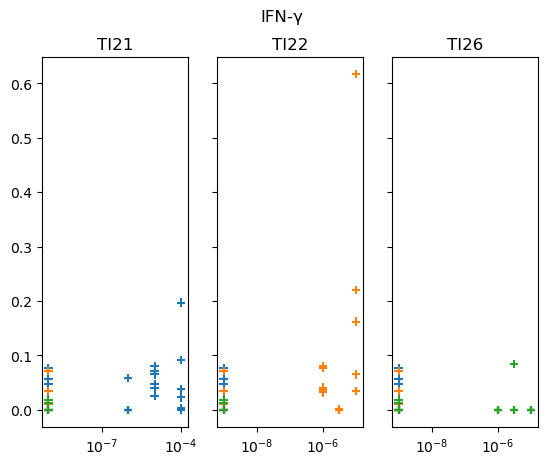

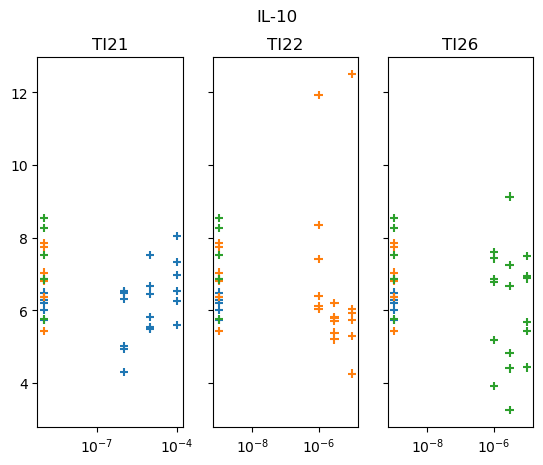

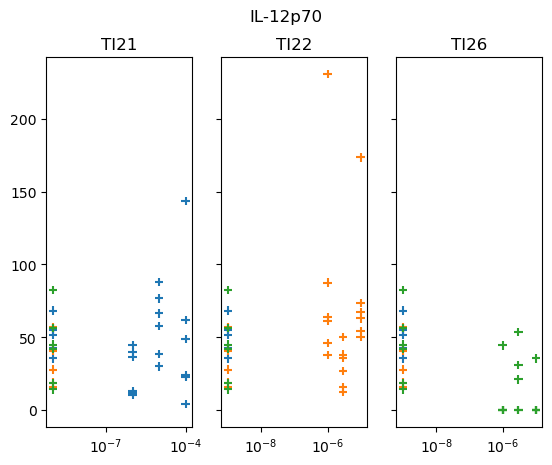

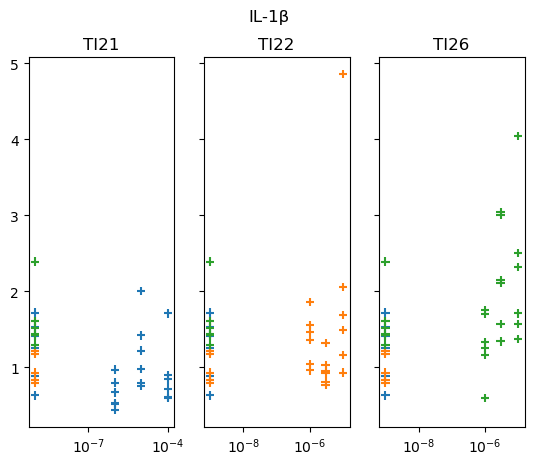

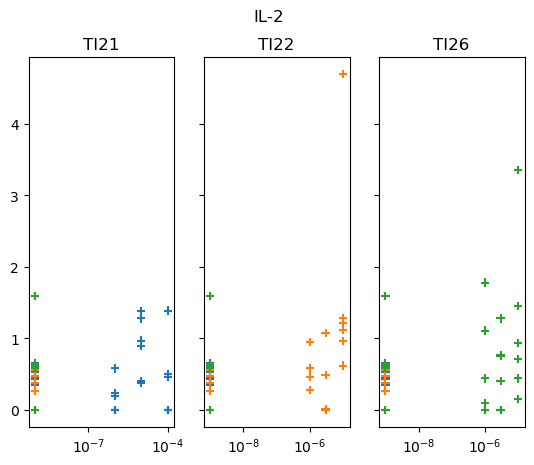

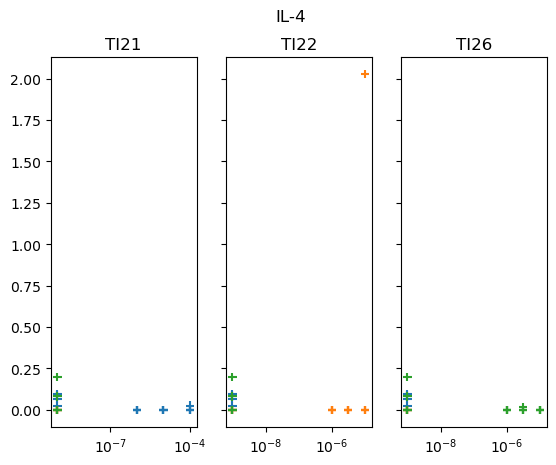

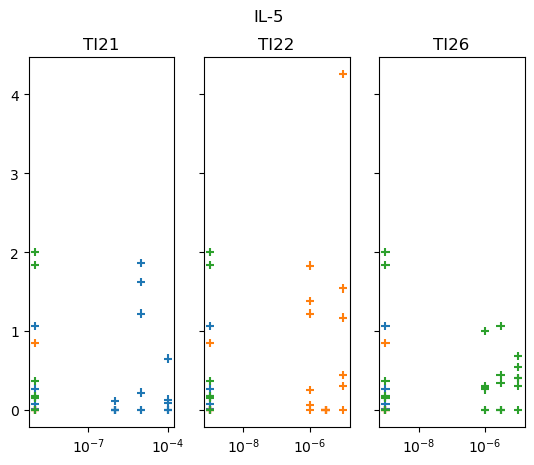

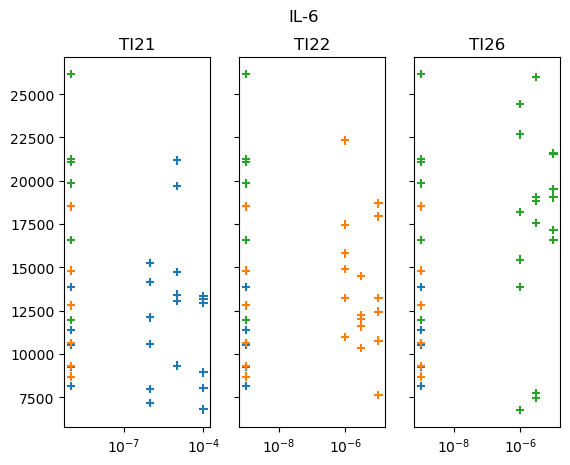

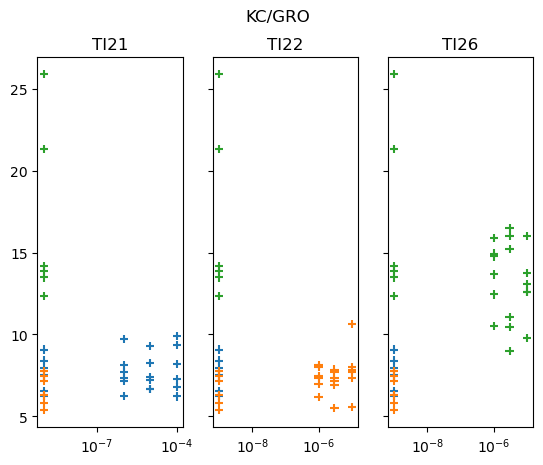

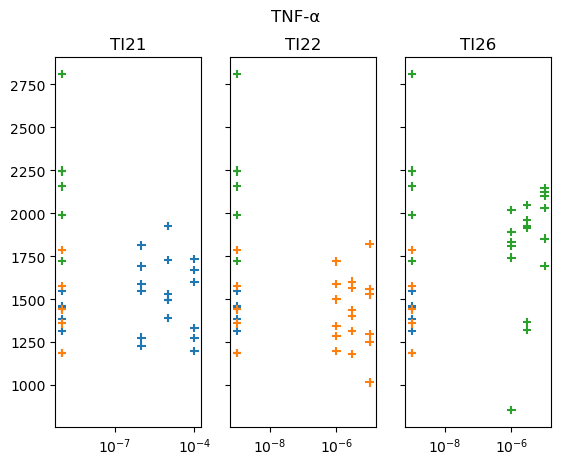

In [12]:
for assay in assays_LPS:
    fig, ax = data_plotter(assay, datad['LPS'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

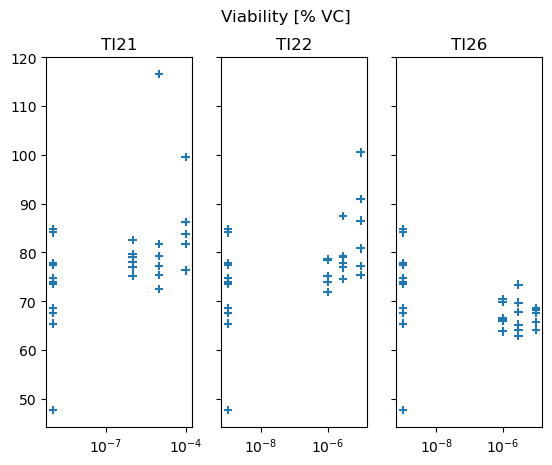

In [13]:
for assay in ['Viability [% VC]']:
    fig, ax = data_plotter(assay, datad['Abeta Toxicity'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

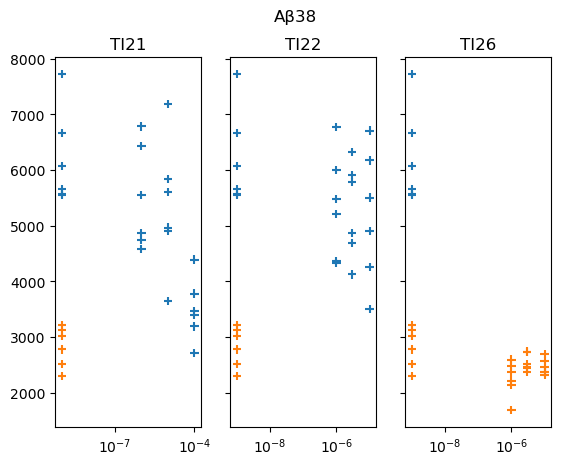

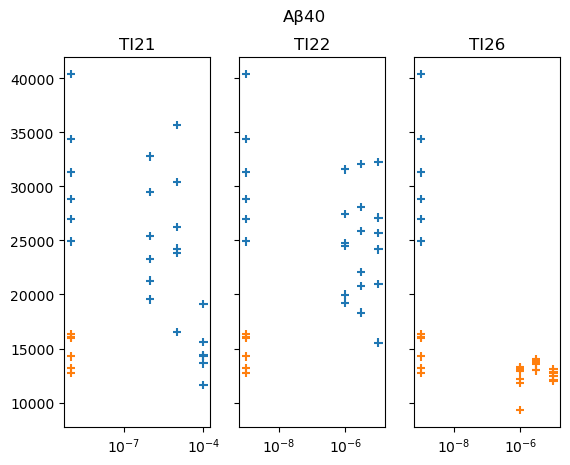

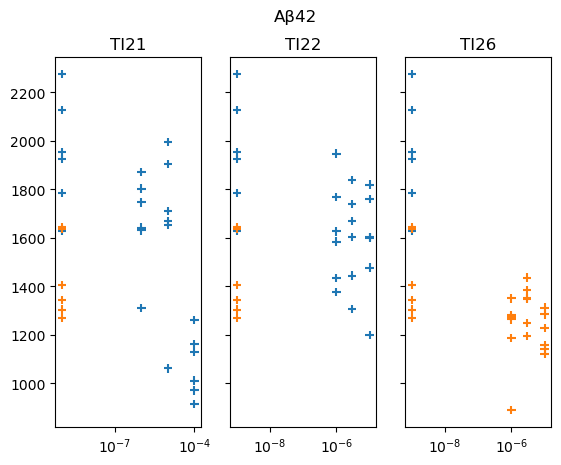

In [14]:
for assay in ['Aβ38', 'Aβ40', 'Aβ42']:
    fig, ax = data_plotter(assay, datad['Abeta release'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

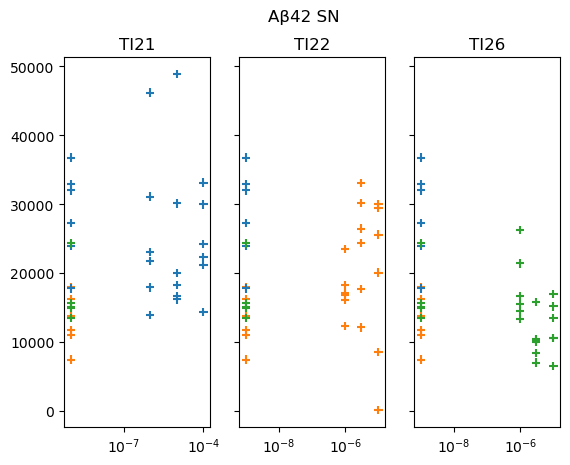

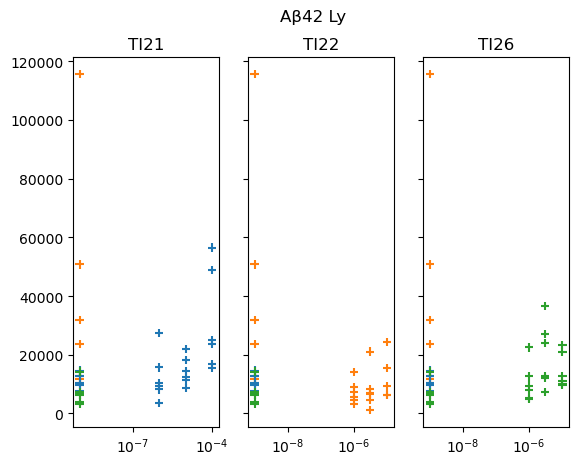

In [15]:
for assay in ['Aβ42 SN', 'Aβ42 Ly']:
    fig, ax = data_plotter(assay, datad['Abeta clearance'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

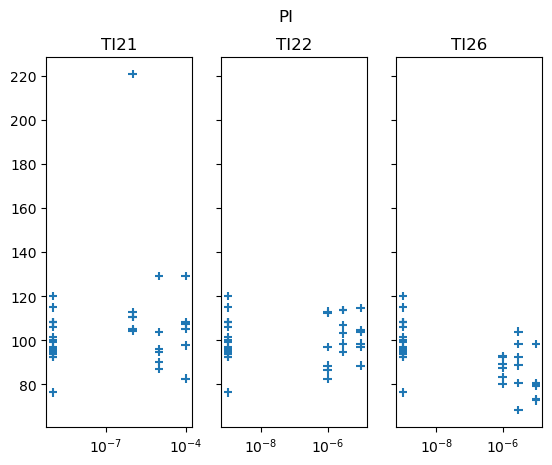

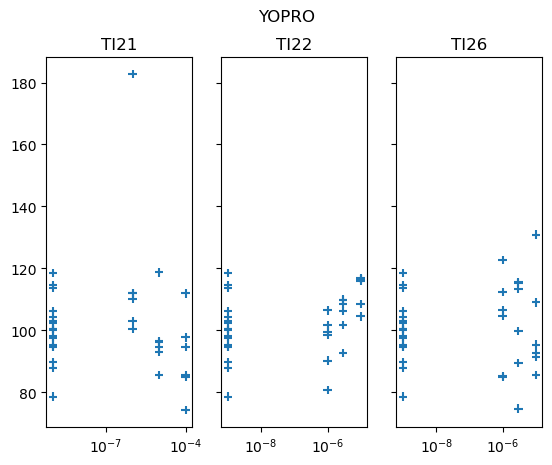

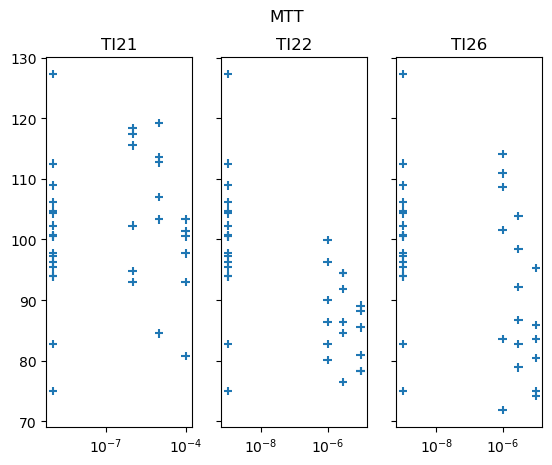

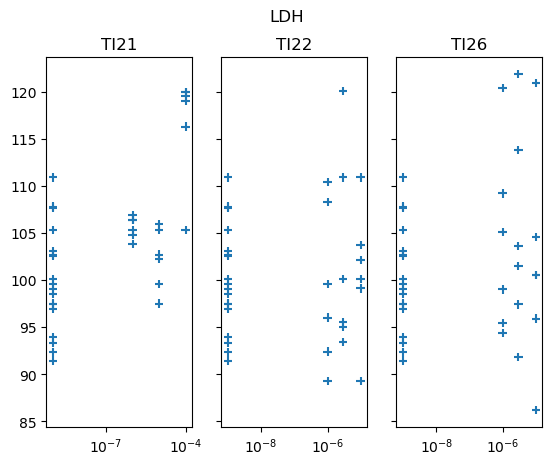

In [16]:
for assay in assays_GF_withdrawal:
    fig, ax = data_plotter(assay, datad['GF withdrawal'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

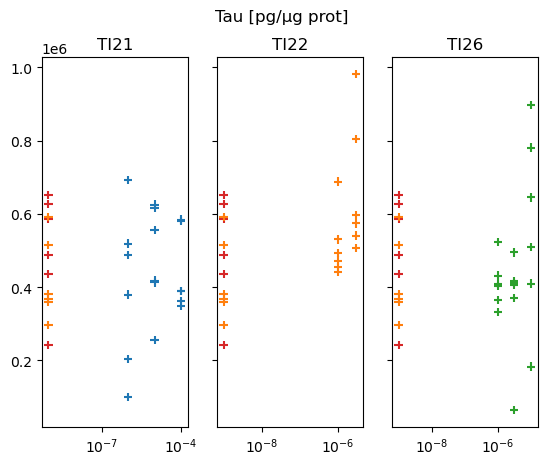

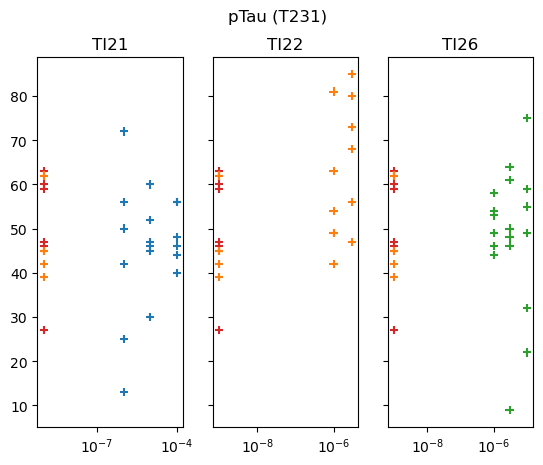

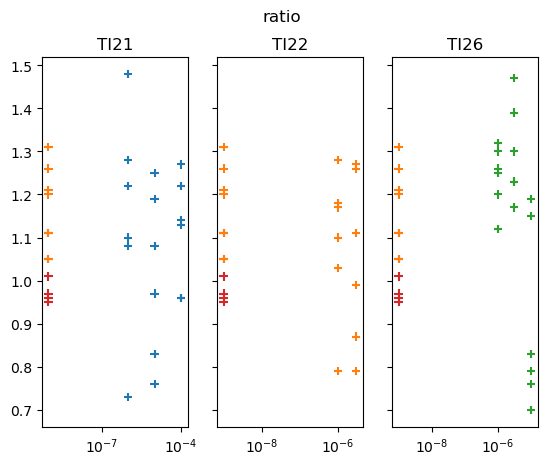

In [17]:
for assay in assays_Tau_phosphorylation:
    fig, ax = data_plotter(assay, datad['Tau phosphorylation'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

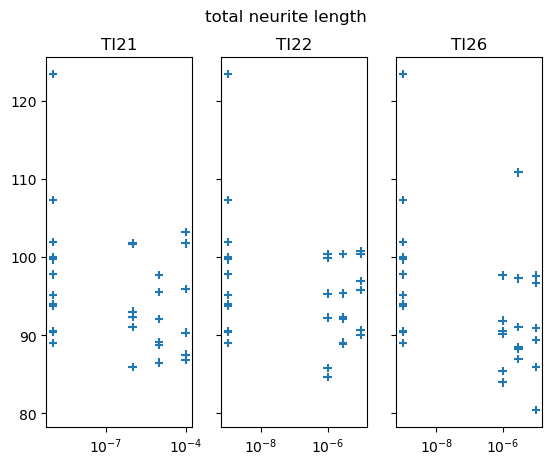

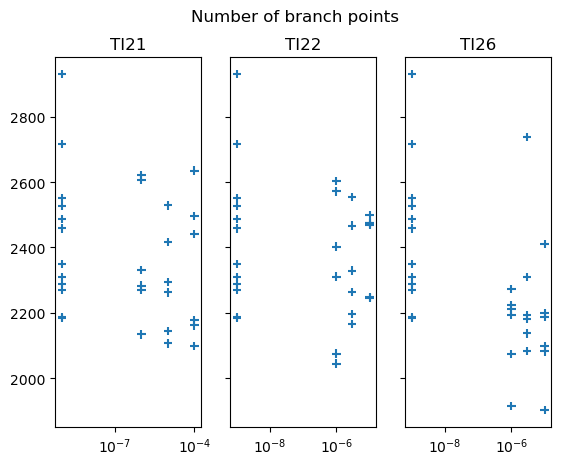

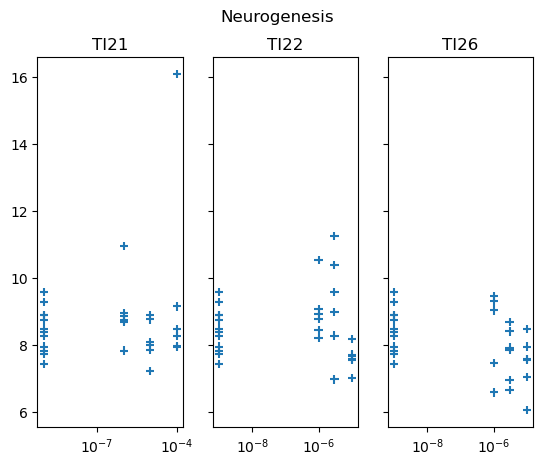

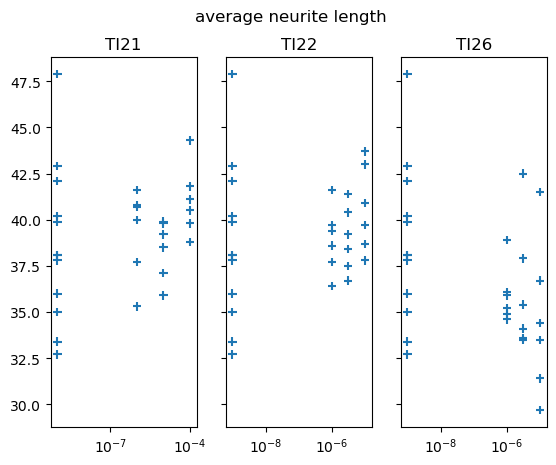

In [18]:
for assay in assays_NOG:
    fig, ax = data_plotter(assay, datad['NOG'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

In [19]:
fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-controls.csv'
controls = pd.read_csv(fpath, index_col='experiment')
controls

control_treatment group_var  TI21  TI22  TI26
experiment                                                       
LPS                               LPS    Cohort   2.0   3.0   5.0
Abeta Toxicity                     LC       NaN   NaN   NaN   NaN
Abeta release                      VC     plate   1.0   1.0   5.0
Abeta clearance                    Aß     plate   2.0   3.0   5.0
GF withdrawal                      VC       NaN   NaN   NaN   NaN
Tau phosphorylation                VC       NaN   NaN   NaN   NaN
NOG                                VC       NaN   NaN   NaN   NaN

In [20]:
def extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=False):
    data = datad[exper]
    group_var, control_treatment, group_level = controls.loc[exper, ['group_var', 'control_treatment', compound]]
    mask = data.TI.isin([compound, control_treatment])
    if group_var is not np.nan:
        mask = mask & (data[group_var] == group_level)
    data = data.loc[mask]
    data_reshaped = data[[assay, 'concentration', 'conc_log10']]
    activity = data_reshaped[assay] / data_reshaped[assay].std() * 10
    data_reshaped = pd.concat([data_reshaped, activity.to_frame('activity')], axis=1)
    if return_data_reshaped:
        return(data_reshaped)
    y_obs = data_reshaped['activity'].values
    x_obs = data_reshaped['conc_log10'].values
    return((y_obs, x_obs))

extract_regr_data('Abeta clearance', 'Aβ42 Ly', 'TI21', return_data_reshaped=True)

Aβ42 Ly  concentration  conc_log10   activity
0   23798.0   1.000000e-04        -4.0  19.181481
1   48934.0   1.000000e-04        -4.0  39.441407
2   16946.0   1.000000e-04        -4.0  13.658685
3   56506.0   1.000000e-04        -4.0  45.544532
4   24963.0   1.000000e-04        -4.0  20.120486
5   15538.0   1.000000e-04        -4.0  12.523819
8   21978.0   1.000000e-05        -5.0  17.714539
9   11275.0   1.000000e-05        -5.0   9.087789
10  14386.0   1.000000e-05        -5.0  11.595293
11  18214.0   1.000000e-05        -5.0  14.680708
12   8740.0   1.000000e-05        -5.0   7.044548
13  12519.0   1.000000e-05        -5.0  10.090468
16   3476.0   1.000000e-06        -6.0   2.801699
17  10450.0   1.000000e-06        -6.0   8.422829
18   9369.0   1.000000e-06        -6.0   7.551529
19  15703.0   1.000000e-06        -6.0  12.656811
20   8196.0   1.000000e-06        -6.0   6.606077
21  27397.0   1.000000e-06        -6.0  22.082319
80   7645.0   1.000000e-09        -9.0   6.161964
81  12677.0   1.000000e-09        -9.0  10.217818
82  14625.0   1.000000e-09        -9.0  11.787930
83  12755.0   1.000000e-09        -9.0  10.280687
84   9818.0   1.000000e-09        -9.0   7.913429
85  10368.0   1.000000e-09        -9.0   8.356736

In [21]:
exper = 'Abeta release'
assay = 'Aβ40'
compound = 'TI21'
data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
model_2, idata_2 = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]
model_4, idata_4 = [cba.sample_sigmoid_4(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
model_names = ['sigmoid 2', 'sigmoid 4']
idatas = [idata_2, idata_4]
var_names = ['EC_50', 'y_0', 'FC_y', 'k', 'y_1']
pd.concat([az.ess(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40             
              TI21             
         sigmoid 2    sigmoid 4
EC_50  1272.835809  1957.623567
y_0    1390.967775  2080.717628
FC_y   1547.588025  1863.473140
k       543.651256   993.531127
y_1    1684.189393  1819.407554

In [23]:
pd.concat([az.rhat(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40          
           TI21          
      sigmoid 2 sigmoid 4
EC_50  1.003560  1.006128
y_0    1.004124  1.000926
FC_y   1.002939  1.002527
k      1.007925  1.007341
y_1    1.001692  1.003008

In [24]:
pd.concat([az.mcse(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40          
           TI21          
      sigmoid 2 sigmoid 4
EC_50  0.010286  0.010693
y_0    0.076734  0.131696
FC_y   0.002667  0.002749
k      2.348334  0.644168
y_1    0.085399  0.121159

['named-figure/mcmc-trace-sigmoid-2.png',
 'named-figure/mcmc-trace-sigmoid-2.pdf']

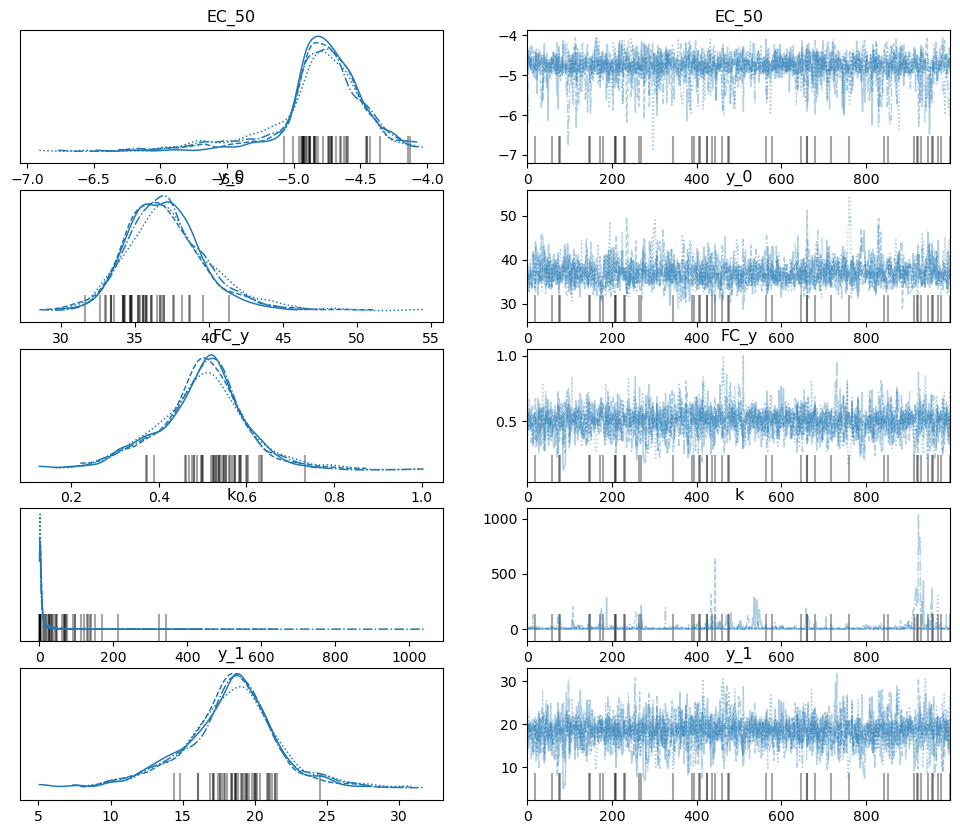

In [25]:
ax = az.plot_trace(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-trace-sigmoid-2')

['named-figure/mcmc-autocorr-sigmoid-2.png',
 'named-figure/mcmc-autocorr-sigmoid-2.pdf']

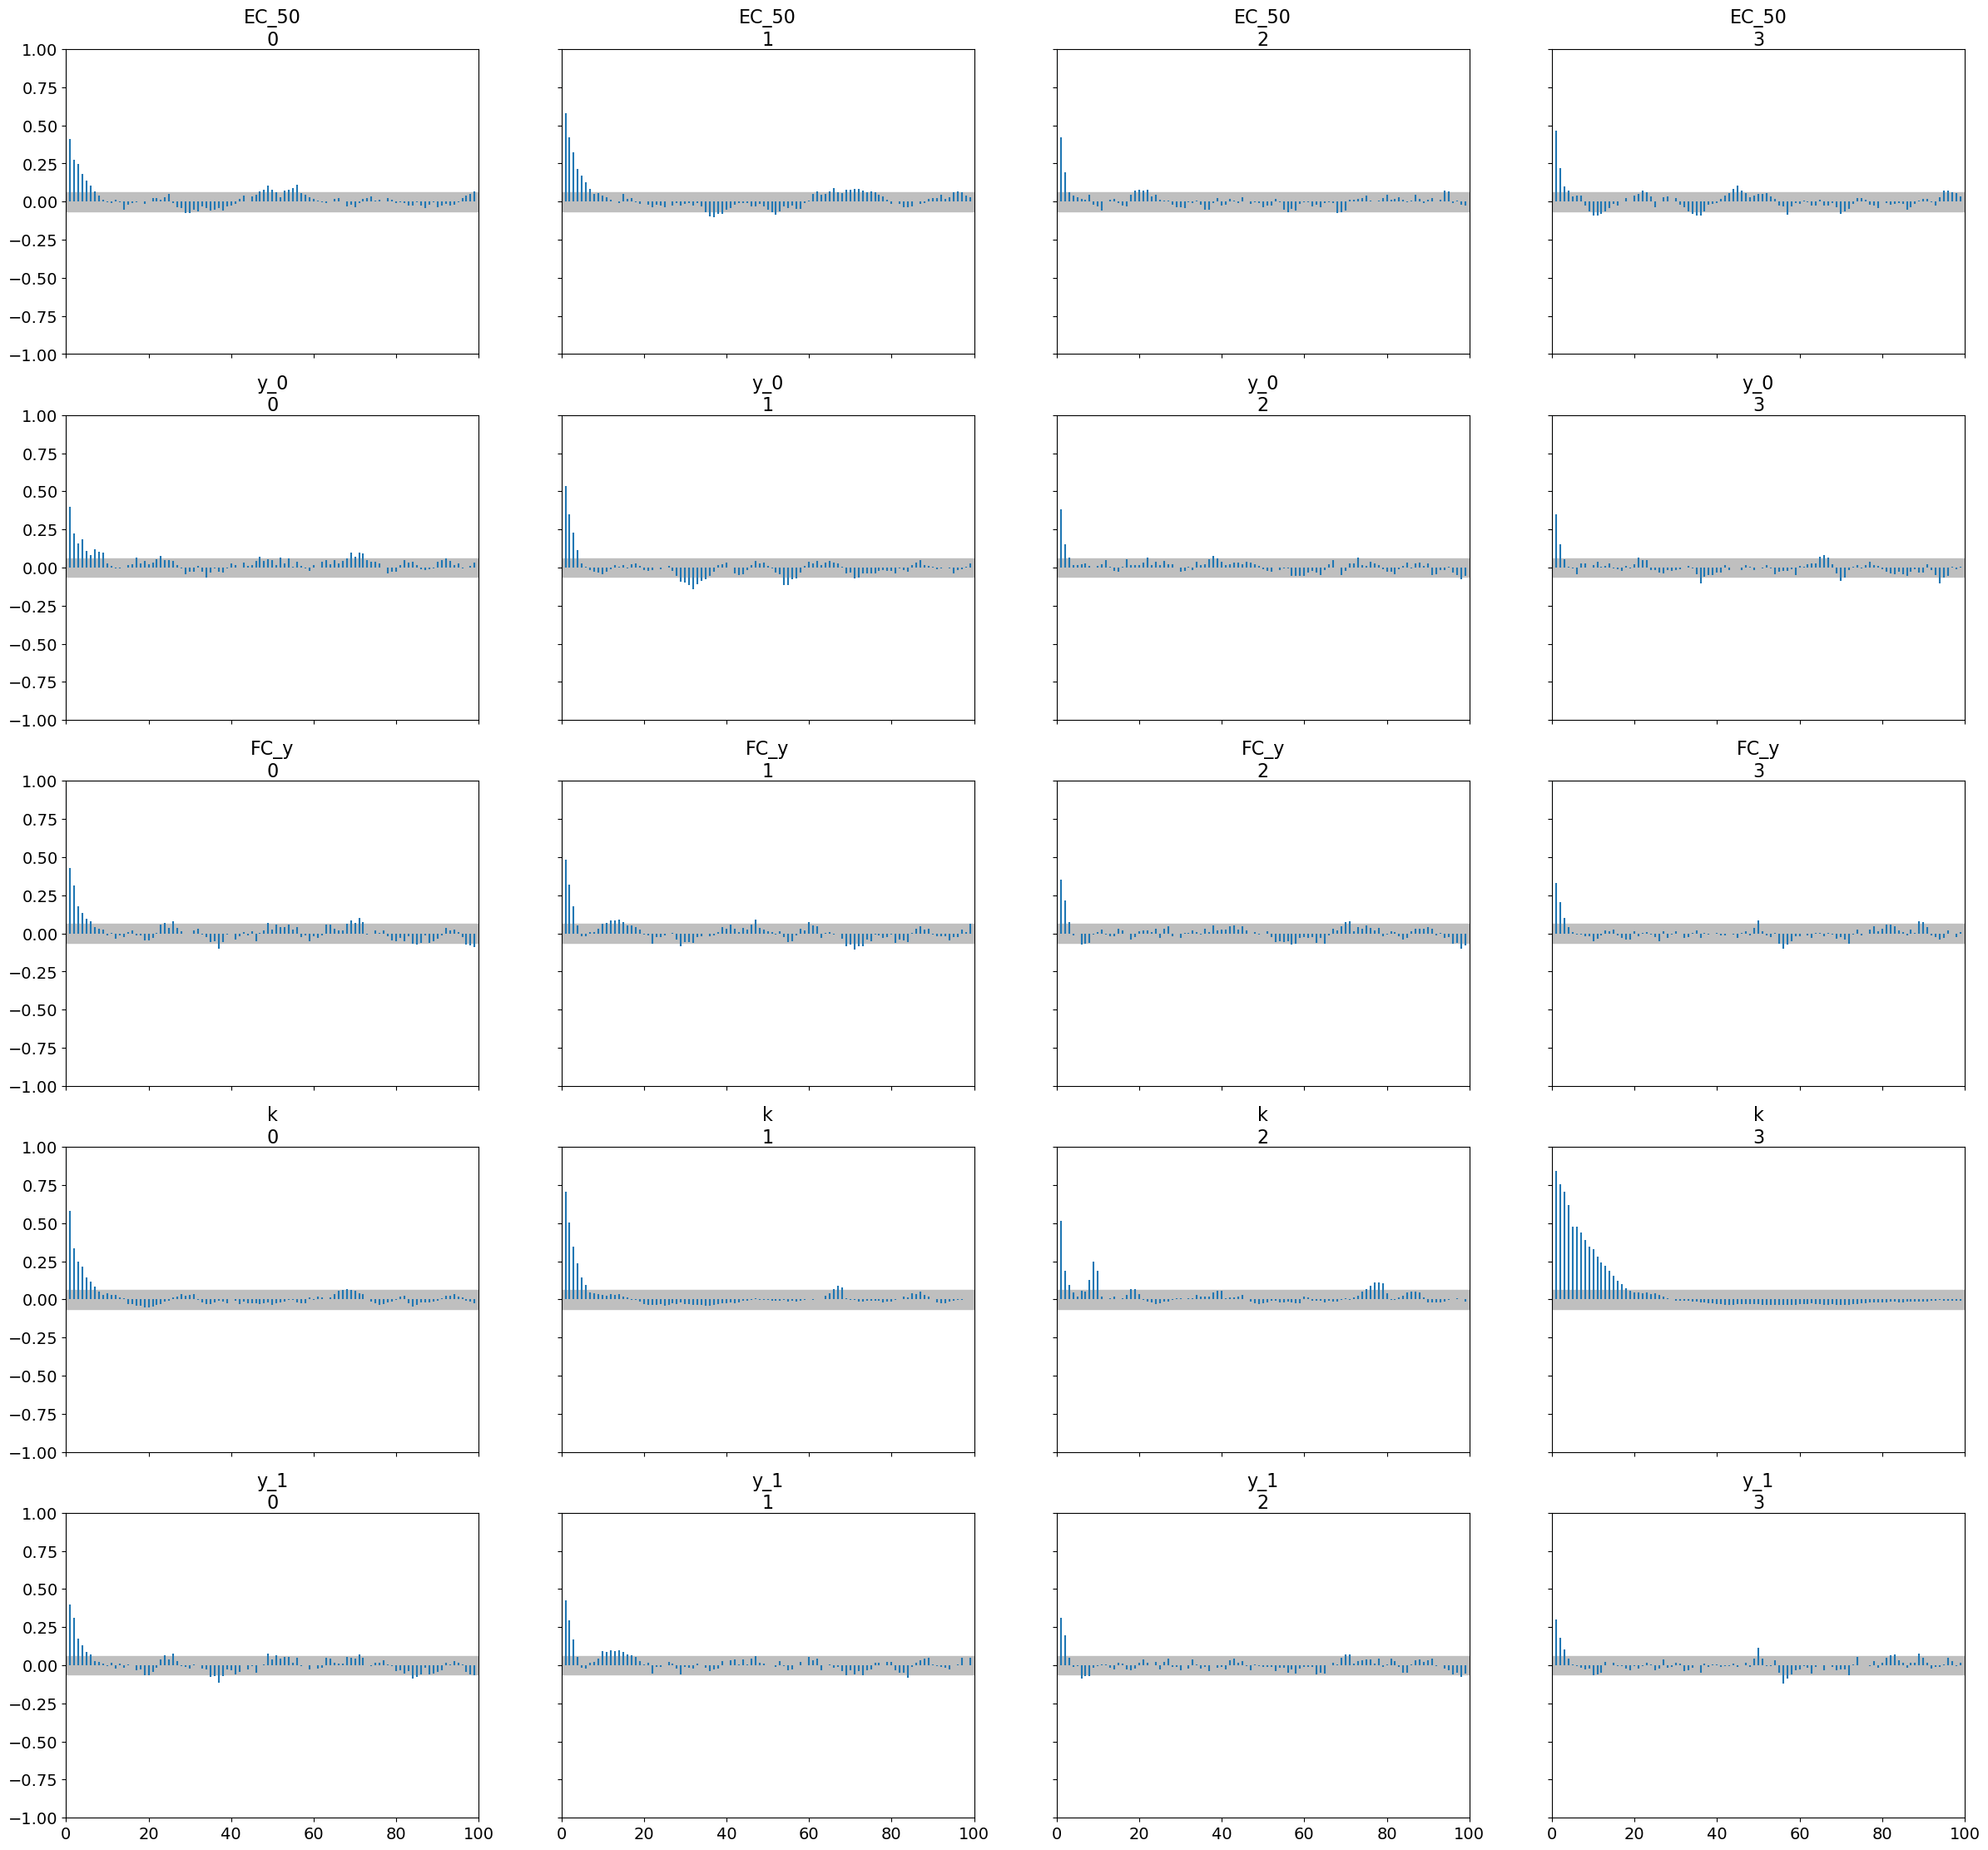

In [26]:
ax = az.plot_autocorr(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-autocorr-sigmoid-2')

['named-figure/mcmc-autocorr-sigmoid-2.png',
 'named-figure/mcmc-autocorr-sigmoid-2.pdf']

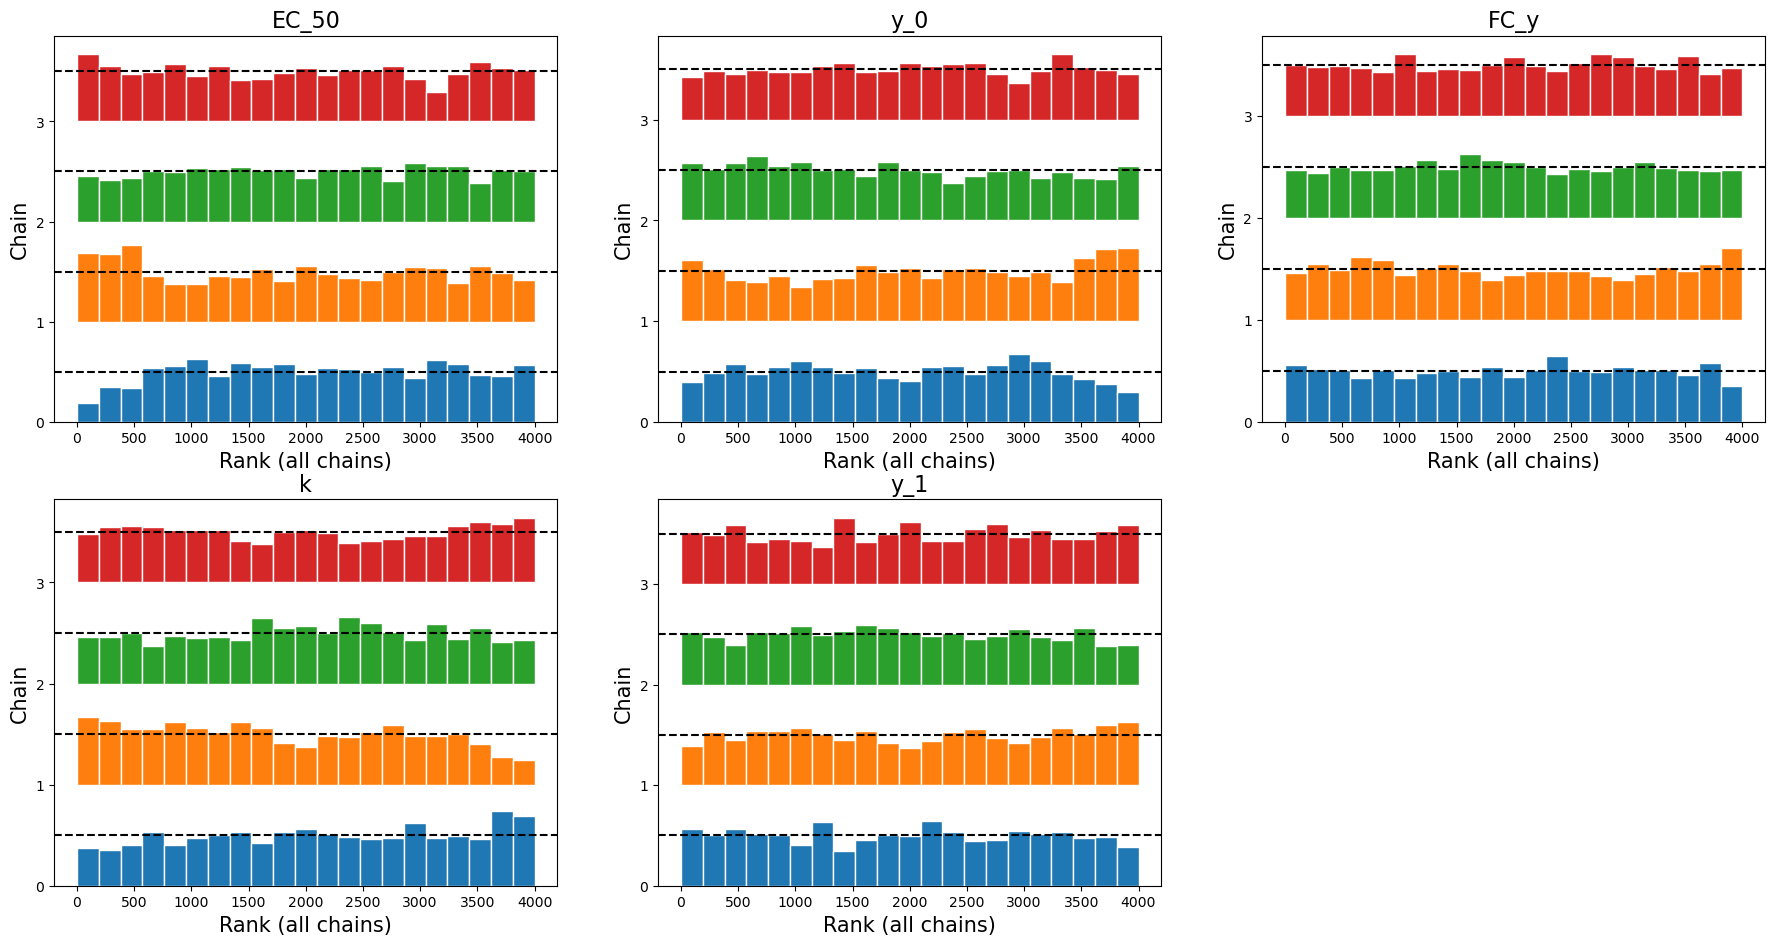

In [27]:
az.plot_rank(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-autocorr-sigmoid-2')

In [28]:
prior_samples_2, prior_samples_4 = [pm.sample_prior_predictive(1000, model) for model in [model_2, model_4]]

Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]


Sampling: [EC_50, FC_y, k, y, y_0, σ]
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/prior-posterior-curves-sigmoid-2.png',
 'named-figure/prior-posterior-curves-sigmoid-2.pdf']

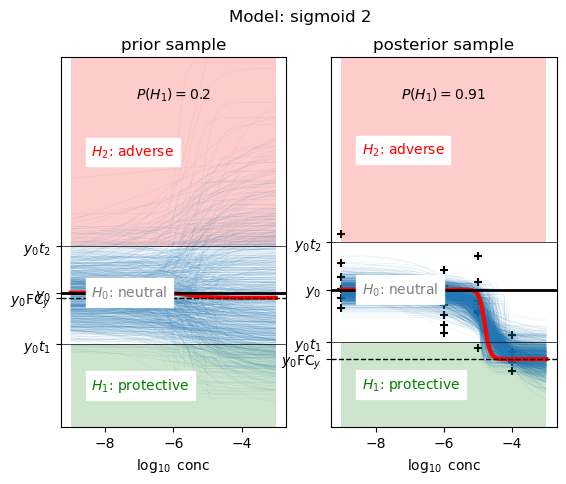

In [29]:
def prior_posterior_curves(model, idata, data_reshaped, H1_increase=False):
    ylim_top = 100
    H1_posterior_prob = cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=H1_increase, H1_prior_prob=cba.default_H1_prior_prob)
    prior = pm.sample_prior_predictive(1000, model, random_seed=1986).prior
    fig, ax = plt.subplots(1, 2, sharey=False)
    for axi, data, title in zip(ax, [prior, idata.posterior], ['prior sample', 'posterior sample']):
        if title == 'posterior sample':
            axi = cba.plot_data(axi, data_reshaped)
            H1_prob = H1_posterior_prob
        else:
            H1_prob = cba.default_H1_prior_prob
        axi = cba.plot_sampled_curves_sigmoid(ax=axi, idata=data, data_reshaped=data_reshaped, alpha=0.2, draw_y0_y1=True, H1_increase=H1_increase, ylim_top=ylim_top)
        axi.axhline(0, color='k', linewidth=0.5)
        axi.set_title(title)
        axi.set_ylim(0, ylim_top)
        axi.set_ylabel('')
        axi.text(0.5, 0.9, '$P(H_1) = {:.2g}$'.format(H1_prob), horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
    return((fig, ax))

fig, ax = prior_posterior_curves(model_2, idata_2, data_reshaped)
fig.suptitle('Model: sigmoid 2')
attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-2')

Sampling: [EC_50, FC_y, k, y, y_0, α, β]
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/prior-posterior-curves-sigmoid-4.png',
 'named-figure/prior-posterior-curves-sigmoid-4.pdf']

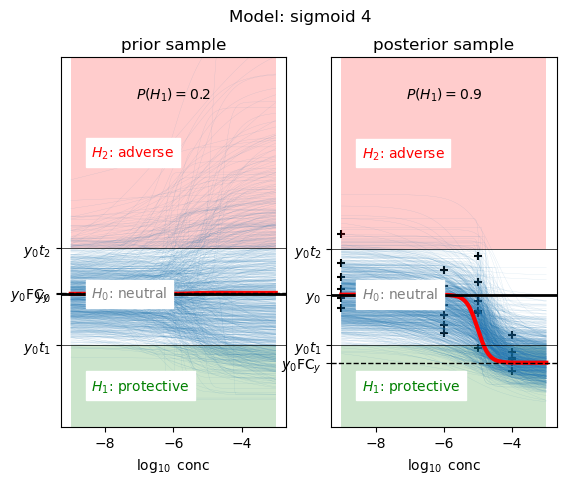

In [30]:
fig, ax = prior_posterior_curves(model_4, idata_4, data_reshaped)
fig.suptitle('Model: sigmoid 4')
attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-4')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:344: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-complex-sigmoid-2.png',
 'named-figure/prior-posterior-density-complex-sigmoid-2.pdf']

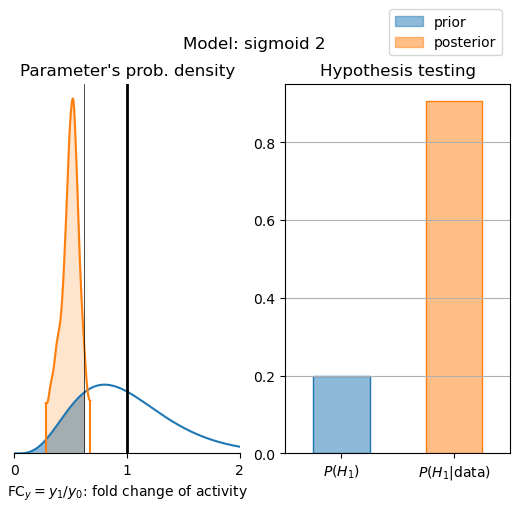

In [31]:
fig, ax = cba.prior_posterior_density_plot_complex(idata_2)
fig.suptitle('Model: sigmoid 2')
ylim_01 = 5.25
ax[0].set_ylim(0, ylim_01)
ylim_11 = 0.95
ax[1].set_ylim(0, ylim_11)
ax[1].grid(axis='y')
attila_utils.savefig(fig, 'prior-posterior-density-complex-sigmoid-2')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:344: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-complex-sigmoid-4.png',
 'named-figure/prior-posterior-density-complex-sigmoid-4.pdf']

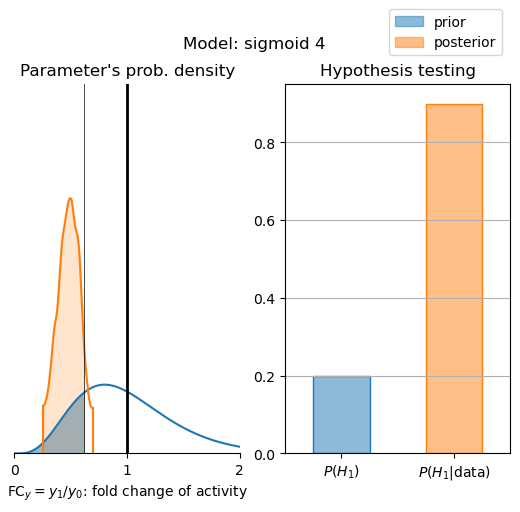

In [32]:
fig, ax = cba.prior_posterior_density_plot_complex(idata_4)
fig.suptitle('Model: sigmoid 4')
ax[0].set_ylim(0, ylim_01)
ax[1].set_ylim(0, ylim_11)
ax[1].grid(axis='y')
attila_utils.savefig(fig, 'prior-posterior-density-complex-sigmoid-4')

In [33]:
prior = 0.2
cba.get_H1_posterior_prob(idata_2.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior)

0.907

In [34]:
def posteriors_priors(idata, model_name):
    priors = 10 ** np.linspace(-2, 0, 9)
    l = [cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior) for prior in priors]
    df = pd.DataFrame(l, index=priors, columns=[model_name])
    return(df)

posteriors_priors_example = pd.concat([posteriors_priors(idata, model_name) for idata, model_name in zip([idata_2, idata_4], model_names)], axis=1)
posteriors_priors_example['prior'] = posteriors_priors_example.index
posteriors_priors_example

sigmoid 2  sigmoid 4     prior
0.010000    0.01500    0.02625  0.010000
0.017783    0.03325    0.05450  0.017783
0.031623    0.08250    0.11450  0.031623
0.056234    0.18025    0.24325  0.056234
0.100000    0.41475    0.50350  0.100000
0.177828    0.85725    0.84925  0.177828
0.316228    0.98900    0.97900  0.316228
0.562341    0.99975    0.99800  0.562341
1.000000    1.00000    1.00000  1.000000

['named-figure/H1-prob-posterior-vs-prior.png',
 'named-figure/H1-prob-posterior-vs-prior.pdf']

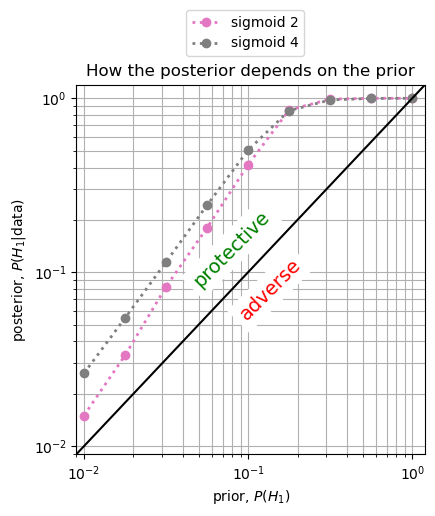

In [35]:
fig, ax = plt.subplots(figsize=(4.5, 4.8))
for p, color in zip(model_names, ['C6', 'C7']):
    ax.plot('prior', p, data=posteriors_priors_example, marker='o', linestyle='dotted', linewidth=2, color=color)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('prior, $P(H_1)$')
ax.set_ylabel('posterior, $P(H_1 | \mathrm{data})$')
ax.set_title('How the posterior depends on the prior')
lim_0 = posteriors_priors_example.min().min() * 0.9
lim_1 = 1.2
ax.set_xlim(lim_0, lim_1)
ax.set_ylim(lim_0, lim_1)
ax.axline((lim_0, lim_0), (lim_1, lim_1), color='k')
ax.grid(which='both')
x_0_min = 4/9
for x_0, my_text, color in zip([x_0_min, 1 - x_0_min], ['protective', 'adverse'], ['green', 'red']):
    ax.text(x_0, 1 - x_0, my_text, horizontalalignment='center', verticalalignment='center',
            rotation=45, transform=ax.transAxes, fontsize=14, color=color, backgroundcolor='white')

attila_utils.savefig(fig, 'H1-prob-posterior-vs-prior')

In [36]:
def fit_single(exper='Abeta release', assay='Aβ38', compound='TI21', datad=datad, controls=controls):
    data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
    try:
        model, idata = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]
    except pm.SamplingError:
        model, idata = (None, None)
    index = pd.MultiIndex.from_product([[compound], ['model', 'idata']])
    columns = pd.MultiIndex.from_product([[exper], [assay]])
    df = pd.DataFrame([model, idata], index=index, columns=columns).transpose()
    return(df)


#df = fit_single(exper='LPS', assay='IL-4', compound='TI22')
#df = fit_single(exper='Abeta release', assay='Aβ38', compound='TI21')
#df

In [37]:
def fit_assay(exper='Abeta release', assay='Aβ38', datad=datad, controls=controls, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_single(exper=exper, assay=assay, compound=c, datad=datad, controls=controls) for c in compounds]
    df = pd.concat(l, axis=1)
    return(df)

#ddf = fit_assay(exper='Abeta release', assay='Aβ38')
#ddf

In [38]:
def fit_exper(exper='Abeta release', datad=datad, controls=controls, assays=assays_Ab_release, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_assay(exper=exper, assay=a, datad=datad, controls=controls, compounds=compounds) for a in assays]
    df = pd.concat(l, axis=0)
    return(df)

#dddf = fit_exper(exper='Abeta release', assays=assays_Ab_release)
#dddf

In [39]:
with open('../../results/2023-09-13-cell-based-assays-bayes/experiments.csv', 'rb') as f:
    experiments = pickle.load(f).drop('TI1', axis=0, level=2)

if False: # True is test mode
    e1 = 'Abeta clearance, iPSC'
    e2 = 'LPS neuroinflammation, iPSC'
    experiments = experiments.loc[[(e1, 'pHrodo-number-4h', 'TI21'), (e1, 'pHrodo-number-4h', 'TI26'), (e2, 'IL-1b', 'TI26')]]

def idatadf_to_netcdf(idatadf, subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/'):
    dirname = maindir + subdir
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    data = idatadf.stack().to_frame('idata')
    l = [dirname + 'idata-' + str(i) + '.nc' for i in np.arange(len(data))]
    fpathdf = pd.DataFrame({'fpath': l}, index=data.index)
    fpathdf.to_csv(maindir + subdir + 'fpaths.csv')
    idata_saveloc = pd.concat([data, fpathdf], axis=1)
    idata_saveloc.apply(lambda r: r.loc['idata'].to_netcdf(r.loc['fpath']), axis=1)
    return(fpathdf)

def idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/'):
    fpathdf = pd.read_csv(maindir + subdir + 'fpaths.csv', index_col=[0,1,2])
    val = fpathdf.apply(lambda row: az.from_netcdf(row.loc['fpath']), axis=1)
    val = val.unstack(level=2).reindex(fpathdf.xs(fpathdf.index.get_level_values(2)[0], axis=0, level=2).index)
    return(val)

if not os.path.exists('../../results/2023-09-26-cell-bayes-assays/idatadf/fpaths.csv'):
    l = [fit_exper(exper=exper, assays=assays) for exper, assays in assayd.items()]
    idata_nonipsc = pd.concat(l, axis=0)
    idata_ipsc = cba.fit_models(models=['sigmoid 2'], experiments=experiments)
    idata_ipsc = idata_ipsc.unstack().swaplevel(1, 2, axis=1).sort_index(level=2, axis=1, ascending=True).sort_index(level=1, axis=1).xs('sigmoid 2', level=0, axis=1)
    blank = pd.DataFrame(np.reshape(np.repeat(None, idata_ipsc.shape[0] * 2), [idata_ipsc.shape[0], 2]), index=idata_ipsc.index, columns=pd.MultiIndex.from_product([['TI22'], ['idata', 'model']]))
    idata_ipsc = pd.concat([idata_ipsc, blank], axis=1)
    idatadf = pd.concat([idata_nonipsc, idata_ipsc], axis=0).xs('idata', axis=1, level=1)
    fpathdf = idatadf_to_netcdf(idatadf, subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')
    print('idatadf written to netcdf')
else:
    idatadf = idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')
    print('idatadf read from netcdf')

idatadf = cba.nice_assay_names(idatadf).rename(columns=treatment2drugname)
idatadf

idatadf read from netcdf


Chenodiol  \
Aβ clearance (BV2 cells)                    Aβ42 Ly          (posterior, log_likelihood, sample_stats, obse...   
                                            Aβ42 SN          (posterior, log_likelihood, sample_stats, obse...   
Aβ clearance (iPSC)                         pHrodo-4h        (posterior, log_likelihood, sample_stats, obse...   
                                            supernatant      (posterior, log_likelihood, sample_stats, obse...   
Aβ release (H4 cells)                       Aβ38             (posterior, log_likelihood, sample_stats, obse...   
                                            Aβ40             (posterior, log_likelihood, sample_stats, obse...   
                                            Aβ42             (posterior, log_likelihood, sample_stats, obse...   
Aβ toxicity (primary neurons)               MTT              (posterior, log_likelihood, sample_stats, obse...   
LPS neuroinflammation (BV2 cells)           IFN-γ            (posterior, log_likelihood, sample_stats, obse...   
                                            IL-10            (posterior, log_likelihood, sample_stats, obse...   
                                            IL-12p70         (posterior, log_likelihood, sample_stats, obse...   
                                            IL-1β            (posterior, log_likelihood, sample_stats, obse...   
                                            IL-2             (posterior, log_likelihood, sample_stats, obse...   
                                            IL-4             (posterior, log_likelihood, sample_stats, obse...   
                                            IL-5             (posterior, log_likelihood, sample_stats, obse...   
                                            IL-6             (posterior, log_likelihood, sample_stats, obse...   
                                            KC/GRO           (posterior, log_likelihood, sample_stats, obse...   
                                            TNF-α            (posterior, log_likelihood, sample_stats, obse...   
LPS neuroinflammation (iPSC)                IL-1β            (posterior, log_likelihood, sample_stats, obse...   
                                            IL-6             (posterior, log_likelihood, sample_stats, obse...   
                                            IL-8             (posterior, log_likelihood, sample_stats, obse...   
                                            MTT              (posterior, log_likelihood, sample_stats, obse...   
                                            TNF-α            (posterior, log_likelihood, sample_stats, obse...   
Neurite outgrowth (primary neurons)         branch points    (posterior, log_likelihood, sample_stats, obse...   
                                            longest neurite  (posterior, log_likelihood, sample_stats, obse...   
                                            neurogenesis     (posterior, log_likelihood, sample_stats, obse...   
                                            Σ neurite area   (posterior, log_likelihood, sample_stats, obse...   
Tau phosphorylation                         Tau              (posterior, log_likelihood, sample_stats, obse...   
                                            pT/T ratio       (posterior, log_likelihood, sample_stats, obse...   
                                            pTau (T231)      (posterior, log_likelihood, sample_stats, obse...   
Trophic factor withdrawal (primary neurons) LDH              (posterior, log_likelihood, sample_stats, obse...   
                                            MTT              (posterior, log_likelihood, sample_stats, obse...   
                                            PI               (posterior, log_likelihood, sample_stats, obse...   
                                            YOPRO            (posterior, log_likelihood, sample_stats, obse...   

                                                                                                    Cysteamine

In [40]:
def get_diagnostics(fun=az.ess, var_names=var_names, idatadf=idatadf, return_df=False, nice_assay_names=False):
    def helper(x, var):
        if x in [np.nan, None]:
            return(x)
        else:
            return(fun(x, var_names=var).to_dict()['data_vars'][var]['data'])
    #idat = idatadf.xs('idata', axis=1, level=1)
    def my_applymap(var, idatadf):
        df = idatadf.applymap(lambda x: helper(x, var))
        df.columns = pd.MultiIndex.from_product([df.columns, [var]])
        return(df)
    df = pd.concat([my_applymap(var, idatadf) for var in var_names], axis=1)
    df = df.sort_index(axis=1, level=0)
    if nice_assay_names:
        df = cba.nice_assay_names(df)
    if return_df:
        return(df)
    precision = np.int64(3 - np.round(np.log10(df.mean().mean())))
    val = df.style.format(precision=precision).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')
    return(val)

get_diagnostics(fun=az.ess)

In [41]:
get_diagnostics(fun=az.rhat)

In [42]:
get_diagnostics(fun=az.mcse)

In [43]:
'''
poor_fits = [
    (('LPS', 'IFN-γ'), 'TI26'),
    (('LPS', 'IL-4'), 'TI22'),
    (('Tau phosphorylation', 'ratio'), 'TI22'),
    (('NOG', 'Neurogenesis'), 'TI22'),
]
poor_fits = [
    (('LPS neuroinflammation (BV2 cells)', 'IFN-γ'), 'TI26'),
    #(('LPS', 'IL-4'), 'TI22'),
    (('Tau phosphorylation', 'pT/T ratio'), 'TI26'),
    (('Neurite outgrowth (primary neurons)', 'neurogenesis'), 'TI22'),
]
'''
poor_fits = [
    (('LPS neuroinflammation (BV2 cells)', 'IFN-γ'), 'Arundine'),
    #(('LPS', 'IL-4'), 'Cysteamine'),
    (('Tau phosphorylation', 'pT/T ratio'), 'Arundine'),
    (('Neurite outgrowth (primary neurons)', 'neurogenesis'), 'Cysteamine'),
]

def remove_poorly_fitted(df, replace_val=None, poor_fits=poor_fits):
    data = df.copy()
    for x in poor_fits:
        ix, column = x
        data.loc[ix, column] = replace_val
    return(data)

In [44]:
fpath = '../../resources/cell-based-assays/ideal-effects.csv'
ideal_H1_increase = pd.read_csv(fpath, index_col=['experiment (nice)', 'assay (nice)'], usecols=['experiment', 'assay', 'experiment (nice)', 'assay (nice)', 'H1_increase', 'ideal effect'])
ideal_H1_increase['H2_increase'] = ~ ideal_H1_increase.H1_increase
ideal_H1_increase

experiment  \
experiment (nice)                           assay (nice)                                   
LPS neuroinflammation (BV2 cells)           IFN-γ                                    LPS   
                                            IL-10                                    LPS   
                                            IL-12p70                                 LPS   
                                            IL-1β                                    LPS   
                                            IL-2                                     LPS   
                                            IL-4                                     LPS   
                                            IL-5                                     LPS   
                                            IL-6                                     LPS   
                                            KC/GRO                                   LPS   
                                            TNF-α                                    LPS   
Aβ toxicity (primary neurons)               MTT                           Abeta Toxicity   
Aβ release (H4 cells)                       Aβ38                           Abeta release   
                                            Aβ40                           Abeta release   
                                            Aβ42                           Abeta release   
Aβ clearance (BV2 cells)                    Aβ42 SN                      Abeta clearance   
                                            Aβ42 Ly                      Abeta clearance   
Trophic factor withdrawal (primary neurons) PI                             GF withdrawal   
                                            YOPRO                          GF withdrawal   
                                            MTT                            GF withdrawal   
                                            LDH                            GF withdrawal   
Tau phosphorylation                         Tau                      Tau phosphorylation   
                                            pTau (T231)              Tau phosphorylation   
                                            pT/T ratio               Tau phosphorylation   
Neurite outgrowth (primary neurons)         Σ neurite area                           NOG   
                                            branch points                            NOG   
                                            neurogenesis                             NOG   
                                            longest neurite                          NOG   
Aβ clearance (iPSC)                         pHrodo-4h              Abeta clearance, iPSC   
                                            supernatant            Abeta clearance, iPSC   
LPS neuroinflammation (iPSC)                IL-1β            LPS neuroinflammation, iPSC   
                                            IL-6             LPS neuroinflammation, iPSC   
                                            IL-8             LPS neuroinflammation, iPSC   
                                            MTT              LPS neuroinflammation, iPSC   
                                            TNF-α            LPS neuroinflammation, iPSC   

                                                                               assay  \
experiment (nice)                           assay (nice)                               
LPS neuroinflammation (BV2 cells)           IFN-γ                              IFN-γ   
                                            IL-10                              IL-10   
                                            IL-12p70                        IL-12p70   
                                            IL-1β                              IL-1β   
                                            IL-2                                IL-2   
                                            IL-4                                IL-4   
                                            IL-5             

In [45]:
def get_H1_posterior_from_idatadf(idatadf, hypothesis='H1', ideal_H1_increase=ideal_H1_increase):
    data = remove_poorly_fitted(idatadf)
    ll = [[cba.get_H1_posterior_prob(data.loc[ix, drug].posterior['FC_y'], H1_increase=ideal_H1_increase.loc[ix, hypothesis + '_increase']) if data.loc[ix, drug] not in [None, np.nan] else None for drug in data.columns] for ix in data.index]
    H1_posteriors = pd.DataFrame(ll, index=data.index, columns=pd.MultiIndex.from_product([data.columns, [hypothesis]]))
    return(H1_posteriors)

def get_H102_posterior_from_idatadf(idatadf, ideal_H1_increase=ideal_H1_increase):
    H1_posteriors, H2_posteriors = [get_H1_posterior_from_idatadf(idatadf, hypothesis=h, ideal_H1_increase=ideal_H1_increase) for h in ['H1', 'H2']]
    a = 1 - (H1_posteriors.to_numpy() + H2_posteriors.to_numpy())
    H0_posteriors = pd.DataFrame(a, index=idatadf.index, columns=pd.MultiIndex.from_product([idatadf.columns, ['H0']]))
    H102_posteriors = pd.concat([H1_posteriors, H0_posteriors, H2_posteriors], axis=1).sort_index(axis=1, level=0)
    hypotheses = ['H1', 'H0', 'H2']
    columns = pd.MultiIndex.from_product([idatadf.columns, pd.CategoricalIndex(hypotheses, categories=hypotheses, ordered=True)])
    H102_posteriors = H102_posteriors.reindex(columns=columns)
    return(H102_posteriors)

fpath = '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv'
if not os.path.exists(fpath):
    H102_posteriors = get_H102_posterior_from_idatadf(idatadf)
    H102_posteriors.to_csv(fpath)
else:
    H102_posteriors = pd.read_csv(fpath, index_col=[0, 1], header=[0, 1])
    
H102_posteriors = cba.nice_assay_names(H102_posteriors)
H102_posteriors.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='hot')

In [46]:
H102_posteriors.mean(axis=0).to_frame('score').transpose().style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='hot')

['named-figure/H102_posteriors-barchart-e2l_textbox.png',
 'named-figure/H102_posteriors-barchart-e2l_textbox.pdf']

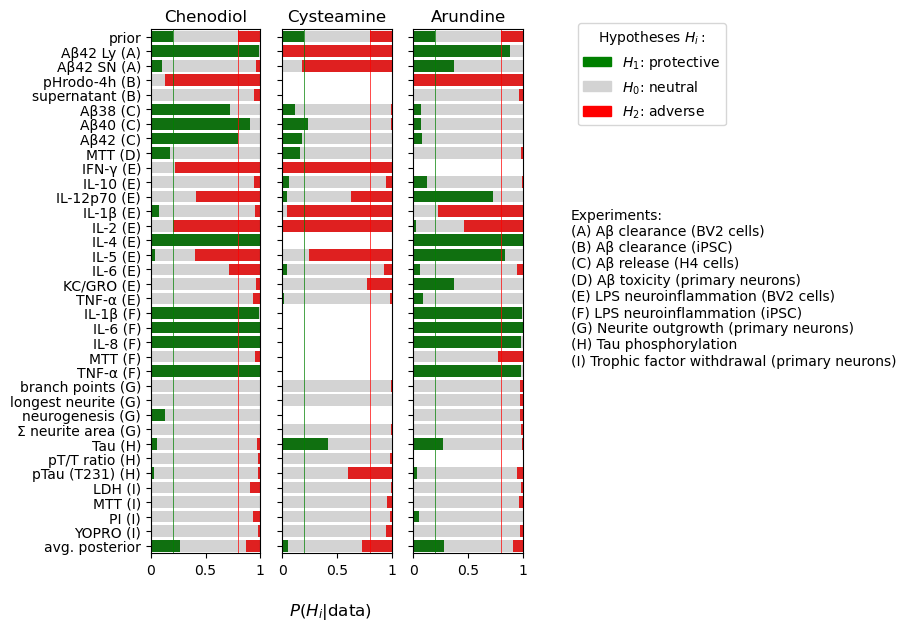

In [47]:
def exper2letter_textbox(fig, exper2letter_d, x, y, horizontalalignment='left', verticalalignment='center'):
    s = '\n'.join(['(' + v + ') ' + k for k, v in exper2letter_d.items()])
    s = 'Experiments:\n' + s
    fig.text(x, y, s, horizontalalignment=horizontalalignment, verticalalignment=verticalalignment)
    return(fig)

def my_legend(g, colors, labels, title='Hypotheses', loc='center left', bbox_to_anchor=(0.5, -0.05, 0.5, 0.5), ncols=3, reverse_labels=False):
    handles = [mpatches.Patch(color=c) for c in colors]
    interpretations = ['protective', 'neutral', 'adverse']
    if reverse_labels:
        handles = reversed(handles)
        labels = reversed(labels)
    g.legend(handles, labels, title=title, loc=loc, bbox_to_anchor=bbox_to_anchor, ncols=ncols)
    return(g)

def barchart_H102_posteriors(H102_posteriors, e2l_textbox=True):
    compounds = H102_posteriors.xs('H0', axis=1, level=1).columns
    fig, ax = plt.subplots(1, len(compounds), figsize=(4.8, H102_posteriors.shape[0]/5), sharey=True)
    d = {'H1': cba.default_H1_prior_prob, 'H0': 1 - 2 * cba.default_H1_prior_prob, 'H2': cba.default_H1_prior_prob}
    df_prior = pd.DataFrame(d, index=pd.MultiIndex.from_product([[''], ['prior']]))
    df_mean_posterior = H102_posteriors.mean(axis=0).to_frame(pd.MultiIndex.from_product([[''], ['avg. posterior']])).transpose()
    for axi, compound in zip(ax, compounds):
        df = H102_posteriors.xs(compound, axis=1, level=0).copy()
        #df = pd.concat([df_prior, df], axis=0)
        df = pd.concat([df_prior, df, df_mean_posterior.xs(compound, axis=1, level=0)], axis=0)
        df_cum = df.cumsum(axis=1)
        k = H102_posteriors.index.get_level_values(0).unique()
        v = string.ascii_uppercase[:len(k)]
        exper2letter_d = dict(zip(k, v))
        y = [a + ' (' + exper2letter_d[e] + ')' for e, a in H102_posteriors.index]
        #y = ['prior'] + y
        y = ['prior'] + y + ['avg. posterior']
        box_alpha = 1
        sns.barplot(ax=axi, data=df, y=y, x='H1', left=0, color='green', alpha=box_alpha)
        sns.barplot(ax=axi, data=df, y=y, x='H0', left=df_cum['H1'], color='lightgray', alpha=box_alpha)
        sns.barplot(ax=axi, data=df, y=y, x='H2', left=df_cum['H0'], color='red', alpha=box_alpha)
        axi.set_title(compound)
        axi.set_xlabel('')
        axi.set_xticks([0, 0.5, 1])
        axi.set_xticklabels(['0', '0.5', '1'])
        for x, color in zip((cba.default_H1_prior_prob, 1 - cba.default_H1_prior_prob), ('green', 'red')):
            axi.axvline(x, linestyle='solid', color=color, linewidth=0.5)
    if e2l_textbox:
        fig = exper2letter_textbox(fig, exper2letter_d, x=1, y=0.5, horizontalalignment='left', verticalalignment='center')
        #fig = exper2letter_textbox(fig, exper2letter_d, x=0, y=1, horizontalalignment='left', verticalalignment='bottom')
    fig.supxlabel('$P(H_i|\mathrm{data})$')
    bbox_to_anchor = (1, 0.9) if e2l_textbox else (0.5, -0.01)
    title = 'Hypotheses $H_i:$'
    loc = 'upper left' if e2l_textbox else 'upper center'
    ncols = 1 if e2l_textbox else 3
    colors = ['green', 'lightgray', 'red']
    labels = ['$H_' + str(i) + '$: ' + interpret for i, interpret in zip([1, 0, 2], ['protective', 'neutral', 'adverse'])]
    my_legend(fig, colors=colors, labels=labels, loc=loc, bbox_to_anchor=bbox_to_anchor, title=title, ncols=ncols)
    return((fig, ax))

fig, ax = barchart_H102_posteriors(H102_posteriors, e2l_textbox=True)
attila_utils.savefig(fig, 'H102_posteriors-barchart-e2l_textbox')

['named-figure/H102_posteriors-barchart.png',
 'named-figure/H102_posteriors-barchart.pdf']

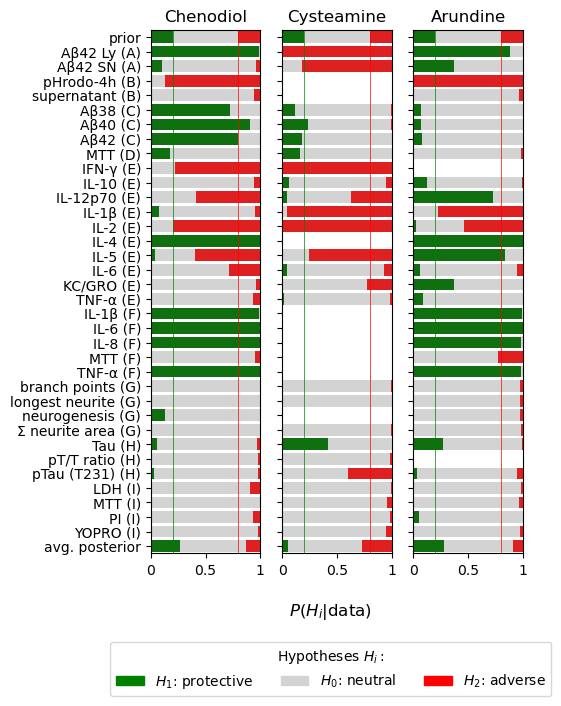

In [48]:
fig, ax = barchart_H102_posteriors(H102_posteriors, e2l_textbox=False)
attila_utils.savefig(fig, 'H102_posteriors-barchart')

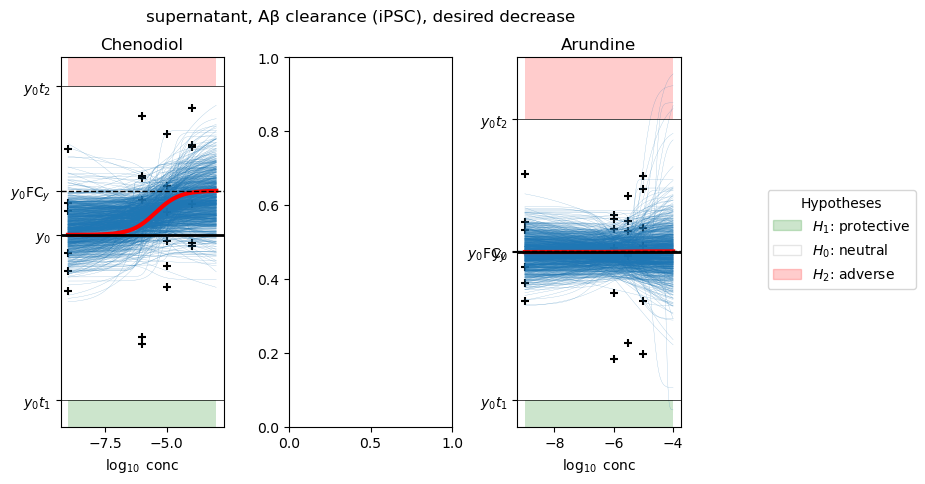

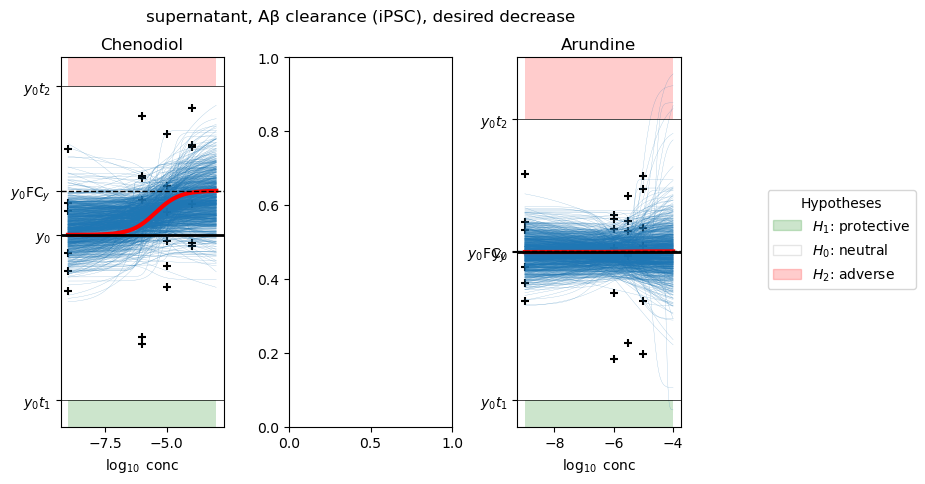

In [49]:
def plot_sampled_curves_one_compound(axi, compound, exper='LPS', assay='IFN-γ', idatadf=idatadf,
                                      ideal_H1_increase=ideal_H1_increase, datad=datad_drugnames,
                                      controls=controls.rename(columns=treatment2drugname),
                                      experiments=experiments.rename(treatment2drugname, axis=0, level=2),
                                      treatment2drugname=treatment2drugname, plot_sampled_curves=True):
    H1_increase = ideal_H1_increase.loc[(exper, assay), 'H1_increase']
    ideal_effect = ideal_H1_increase.loc[(exper, assay), 'ideal effect']
    if idatadf.loc[(exper, assay), compound] in [np.nan, None]:
        return(axi)
    idata = idatadf.loc[(exper, assay), compound].posterior
    e, a = [ideal_H1_increase.loc[(exper, assay), c] for c in ['experiment', 'assay']]
    if exper in ['Aβ clearance (iPSC)', 'LPS neuroinflammation (iPSC)']:
        concentrations, bname = [experiments.loc[(e, a, compound), c] for c in ['concentrations', 'bname']]
        treatment_name = [k for k, v in treatment2drugname.items() if v == compound][0]
        data_reshaped = cba.read_reshape_data(treatment_name, a, concentrations, bname)
    else:
        data_reshaped = extract_regr_data(e, a, compound, datad=datad, controls=controls, return_data_reshaped=True)
    axi = cba.plot_data(axi, data_reshaped)
    axi = cba.plot_sampled_curves_sigmoid(axi, idata, data_reshaped, H1_increase=H1_increase, draw_y0_y1=True, ylim_top=None, H_text=False, plot_sampled_curves=plot_sampled_curves)
    axi.set_ylabel('')
    axi.set_title(compound)
    return(axi)





def plot_sampled_curves_all_compounds(exper='LPS', assay='IFN-γ', idatadf=idatadf,
                                      ideal_H1_increase=ideal_H1_increase, datad=datad_drugnames,
                                      controls=controls.rename(columns=treatment2drugname),
                                      experiments=experiments.rename(treatment2drugname, axis=0, level=2),
                                      treatment2drugname=treatment2drugname):
    ylim_top = 50
    fig, ax = plt.subplots(1, idatadf.shape[1], sharey=False, figsize=(8, 4.8))
    H1_increase = ideal_H1_increase.loc[(exper, assay), 'H1_increase']
    ideal_effect = ideal_H1_increase.loc[(exper, assay), 'ideal effect']
    for axi, compound in zip(ax, idatadf.columns):
        axi = plot_sampled_curves_one_compound(axi, compound, exper=exper, assay=assay, idatadf=idatadf, ideal_H1_increase=ideal_H1_increase, datad=datad,
                                      controls=controls, experiments=experiments, treatment2drugname=treatment2drugname)
    fig.suptitle(assay + ', ' + exper + ', desired ' + ideal_effect)
    lower_color = 'red' if H1_increase else 'green'
    upper_color = 'red' if not H1_increase else 'green'
    middle_color = 'white'
    lower_H = '$H_2$: adverse' if H1_increase else '$H_1$: protective'
    upper_H = '$H_2$: adverse' if not H1_increase else '$H_1$: protective'
    handles = [mpatches.Patch(edgecolor=ec, facecolor=c, alpha=0.2) for c, ec in zip([lower_color, 'white', upper_color], [lower_color, 'gray', upper_color])]
    labels = [lower_H, '$H_0$: neutral', upper_H]
    fig.legend(title='Hypotheses', handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=0.4)
    return(fig)

plot_sampled_curves_all_compounds(exper='Aβ clearance (iPSC)', assay='supernatant')
#plot_sampled_curves_all_compounds(exper='LPS neuroinflammation (BV2 cells)', assay='IL-4')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

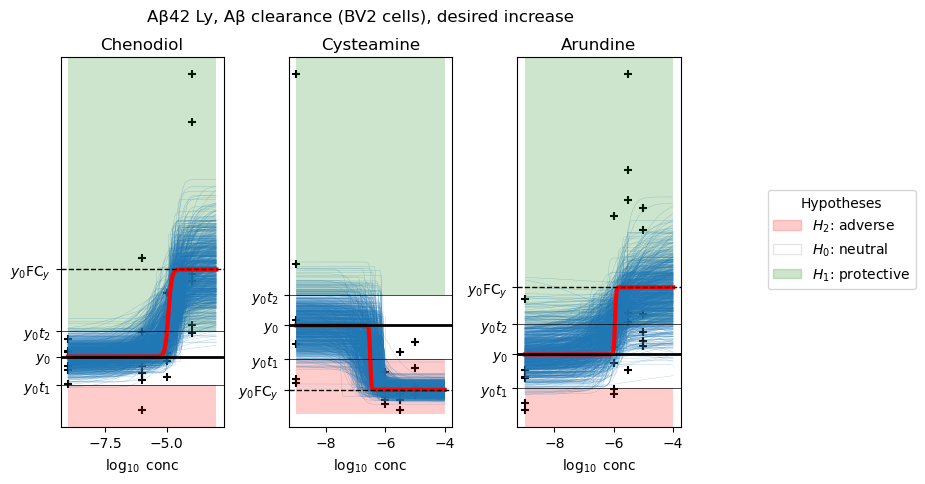

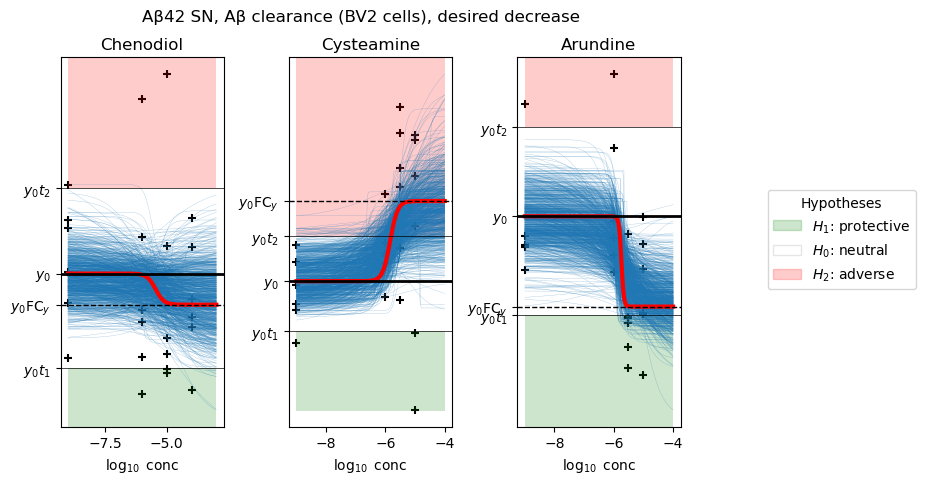

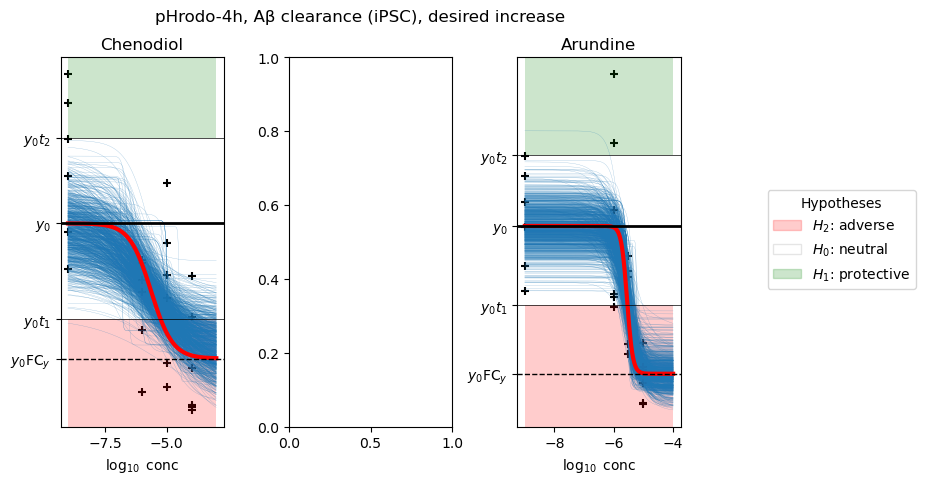

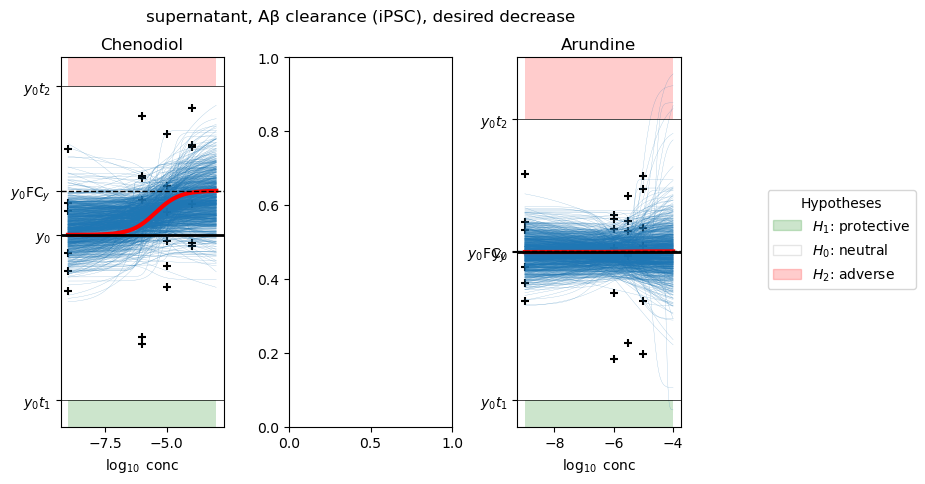

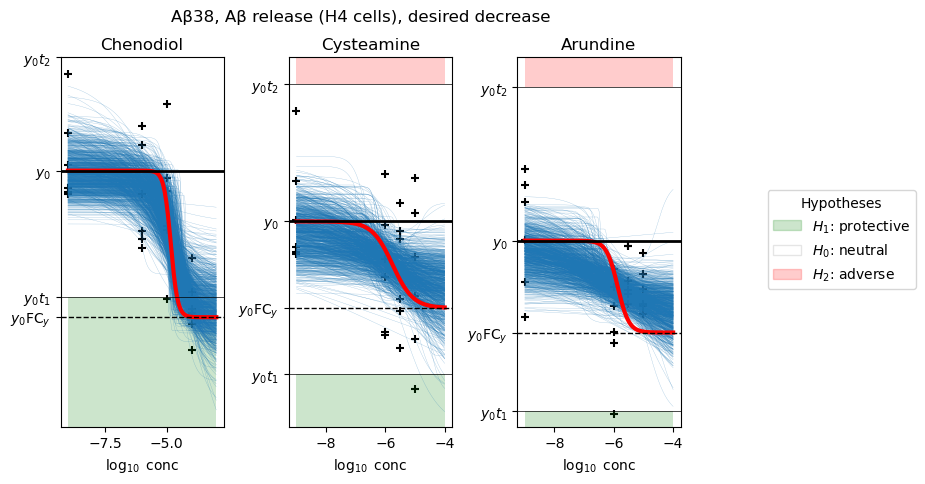

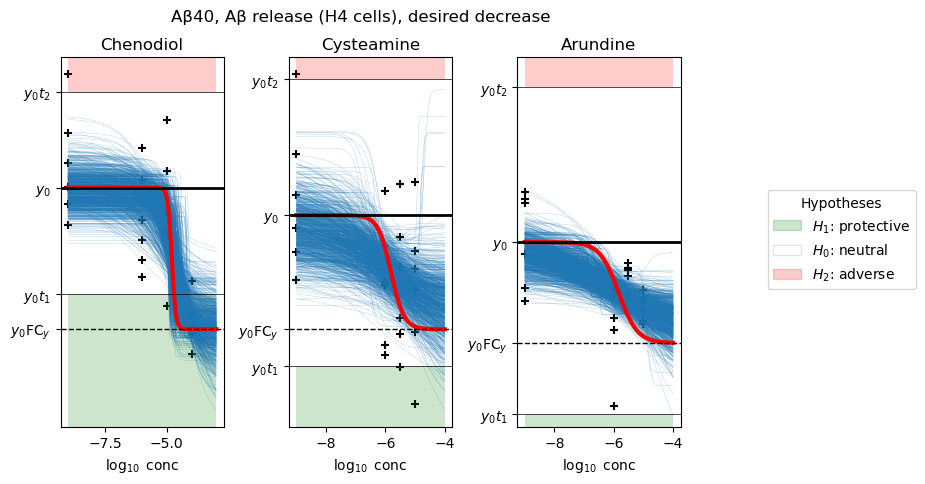

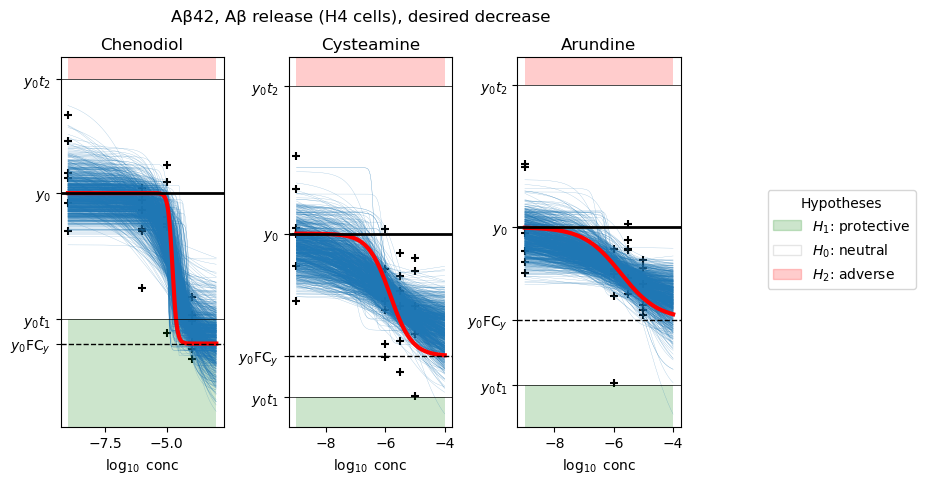

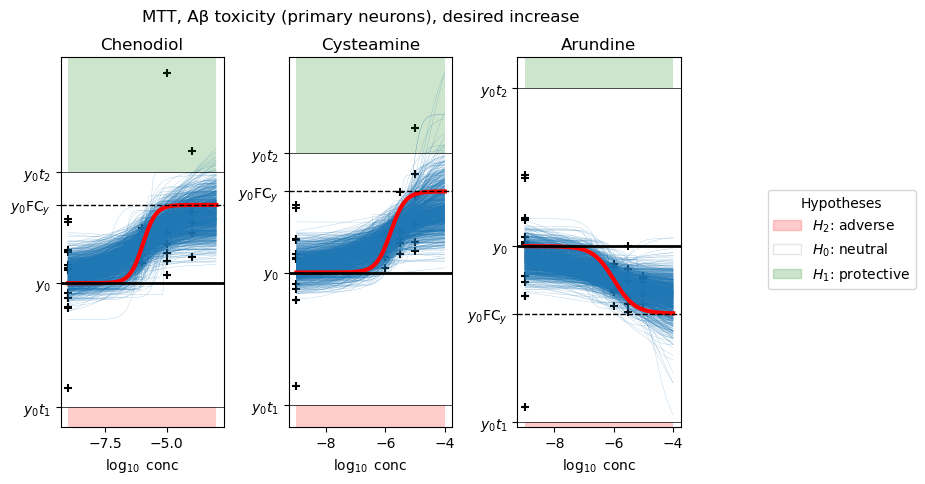

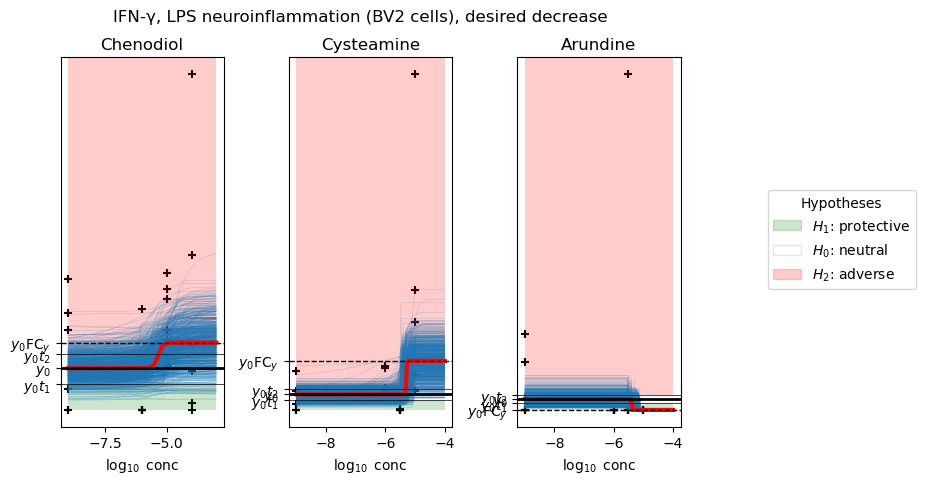

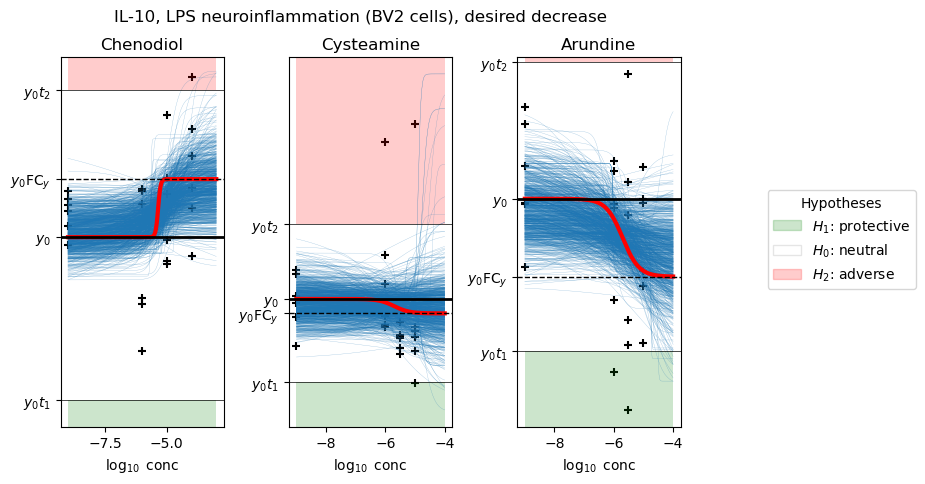

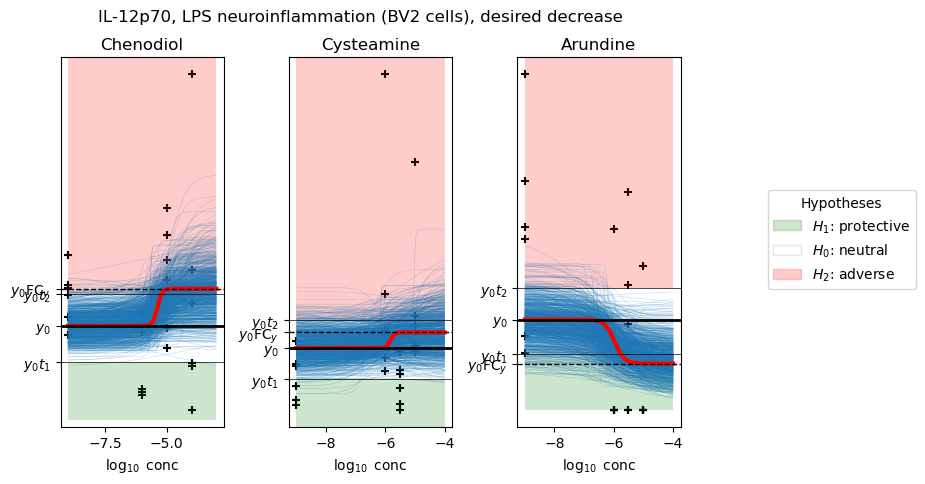

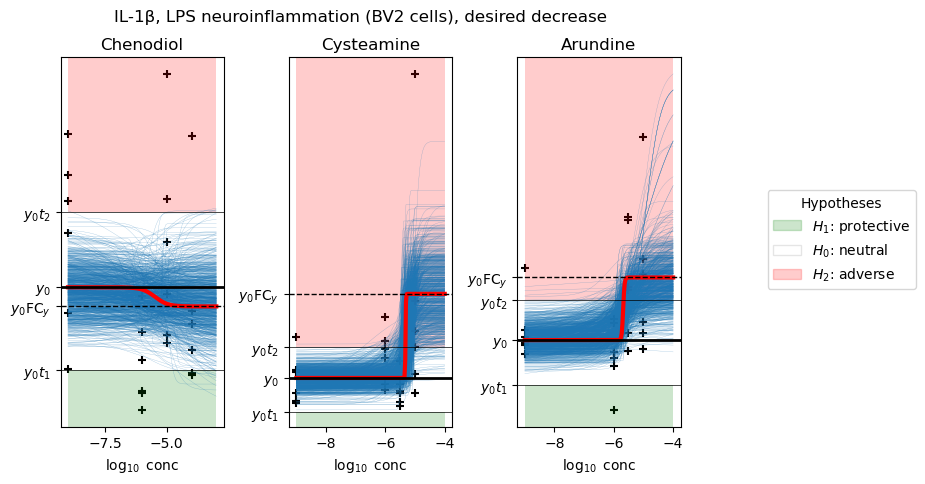

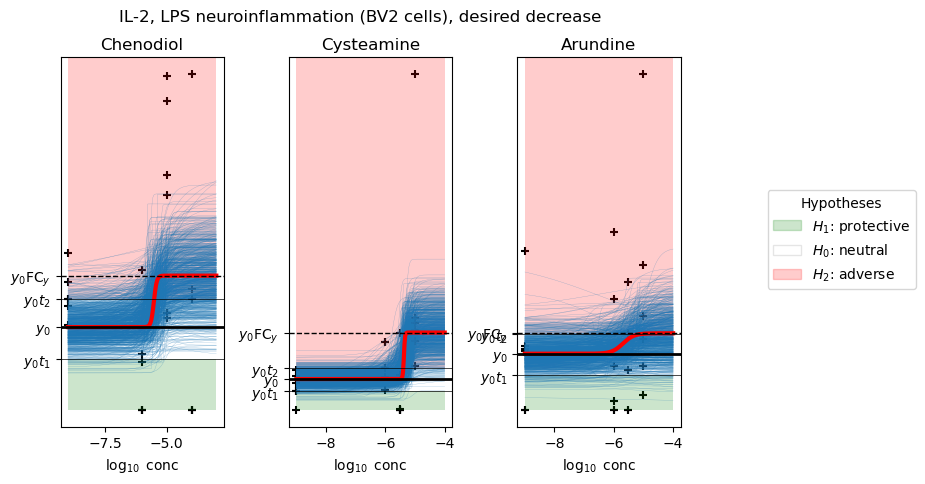

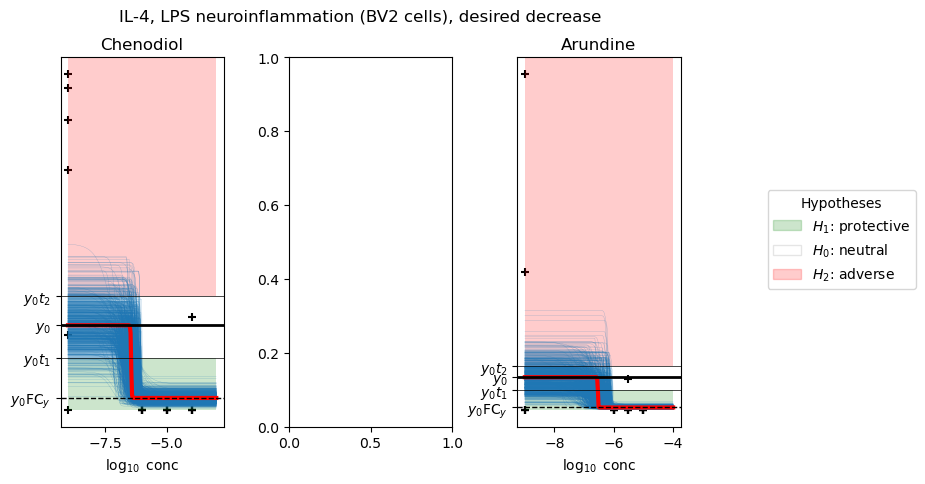

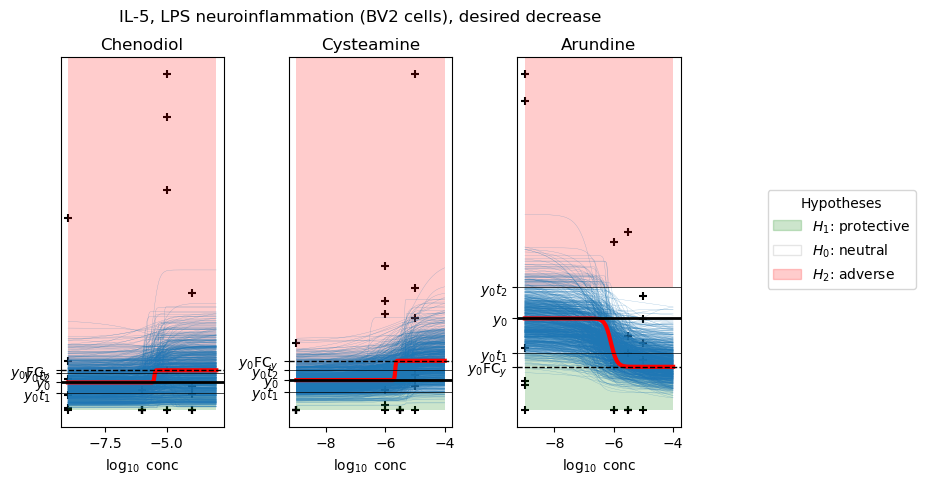

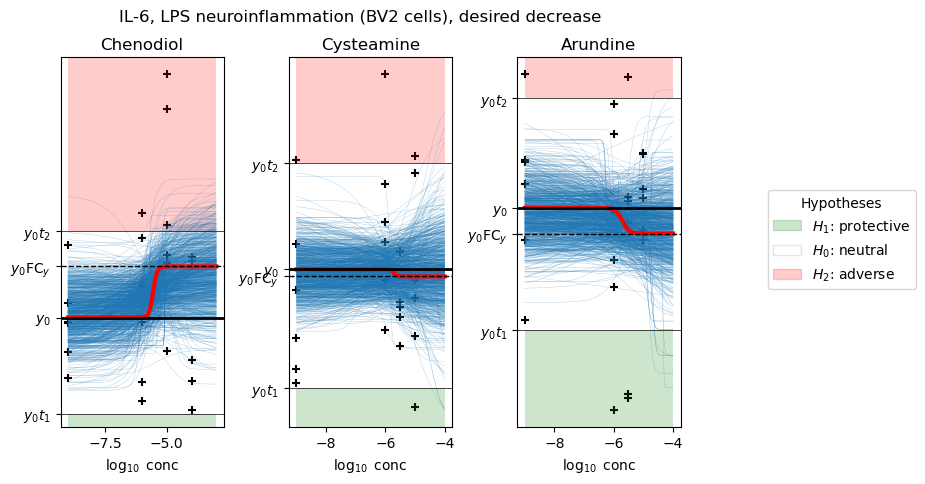

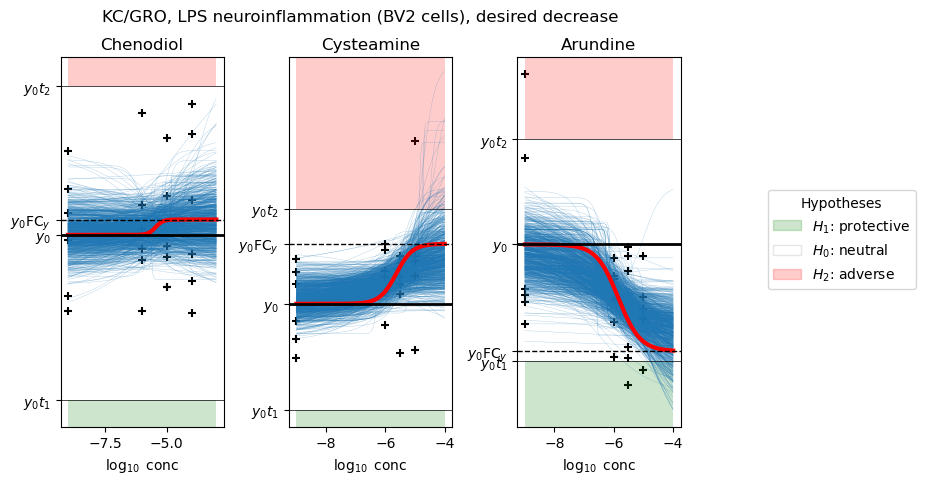

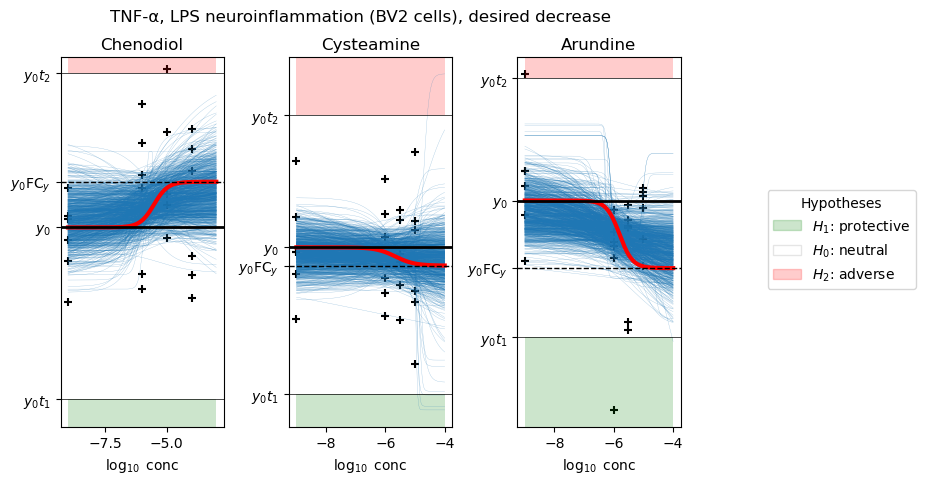

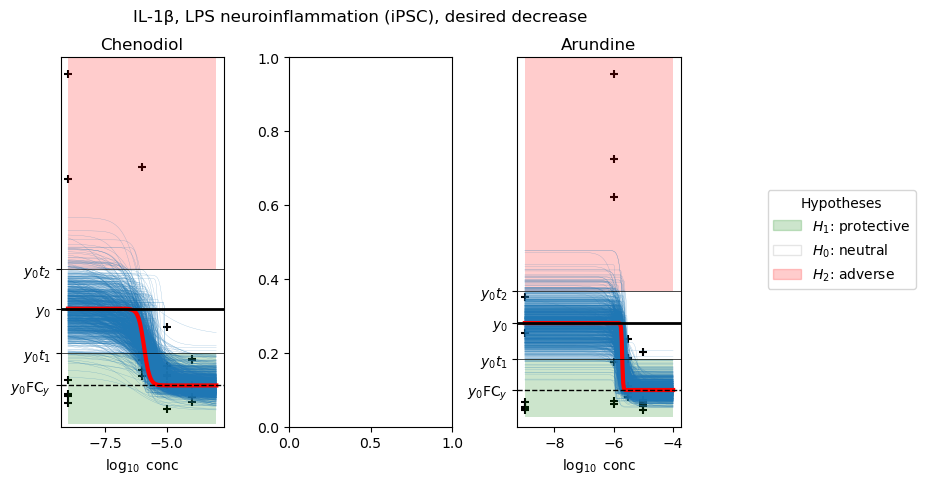

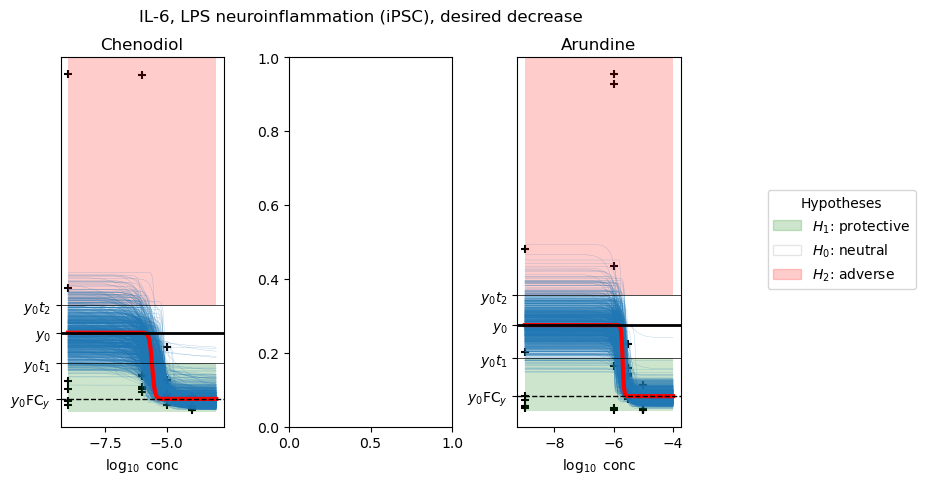

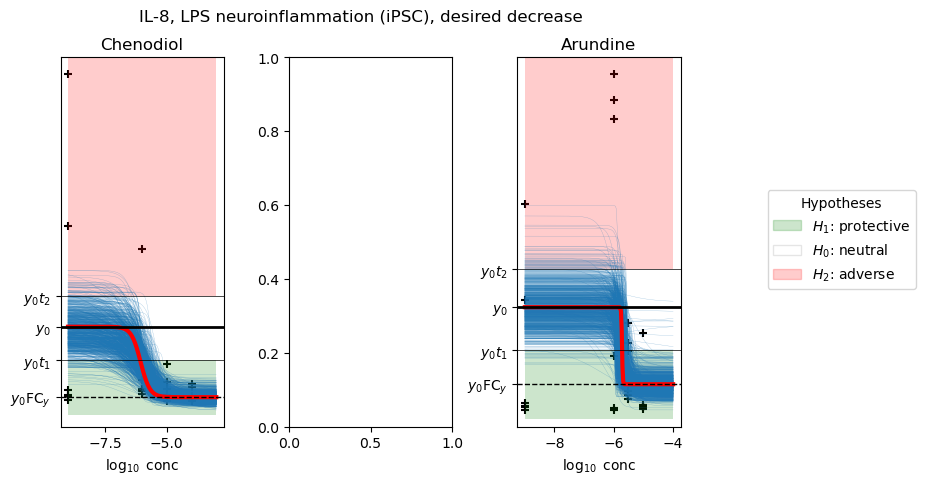

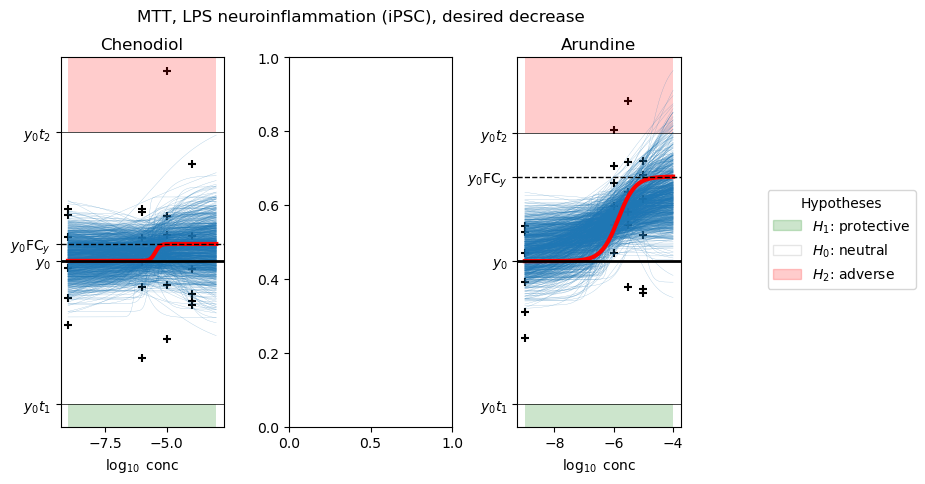

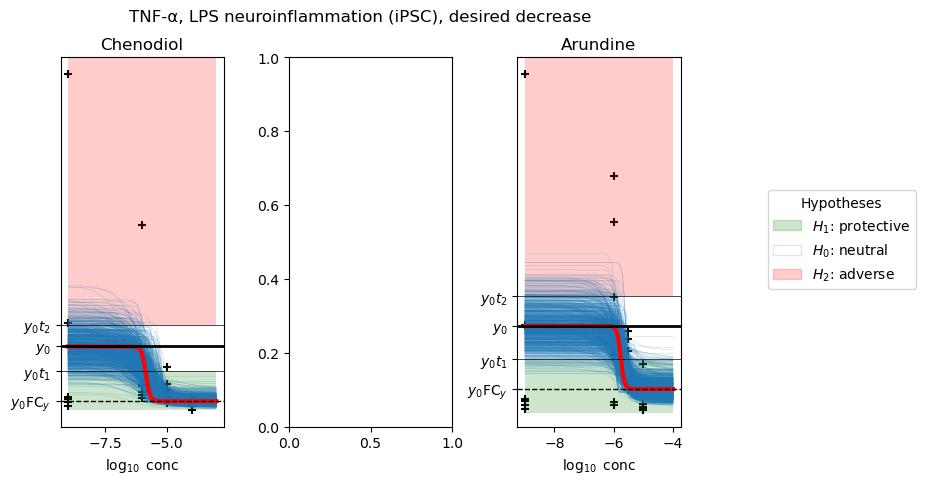

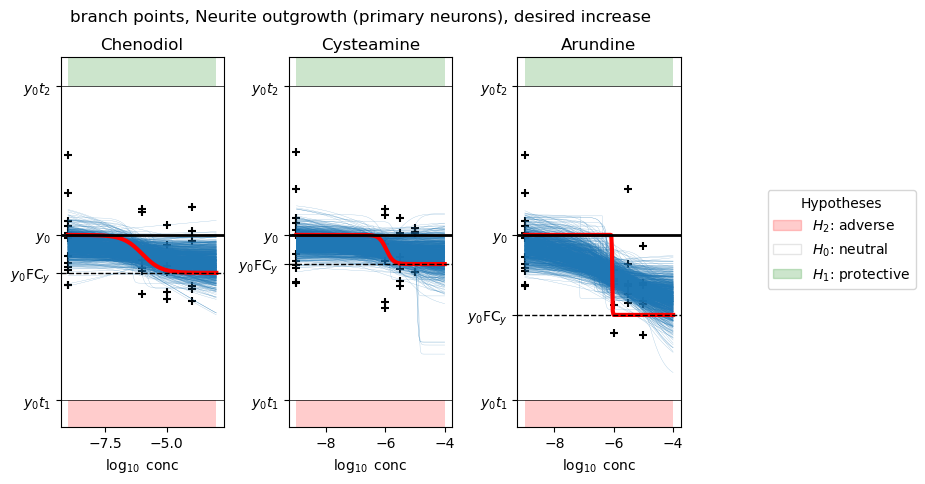

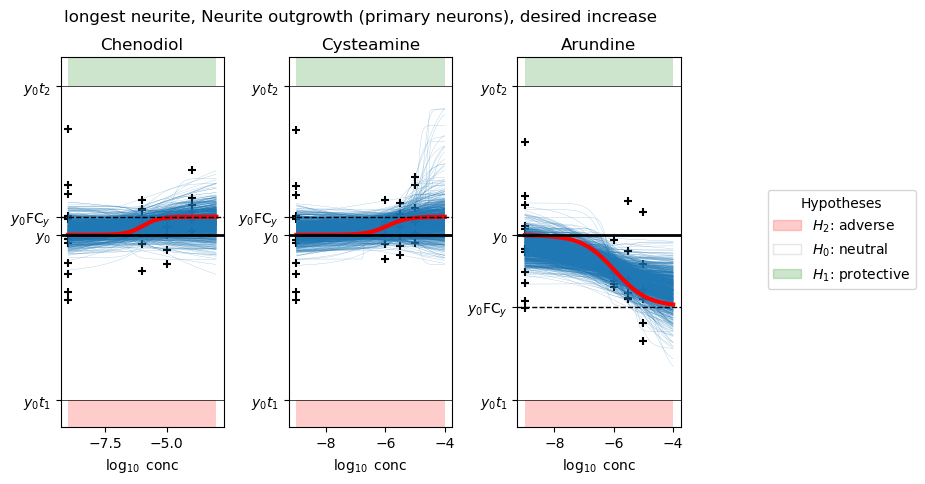

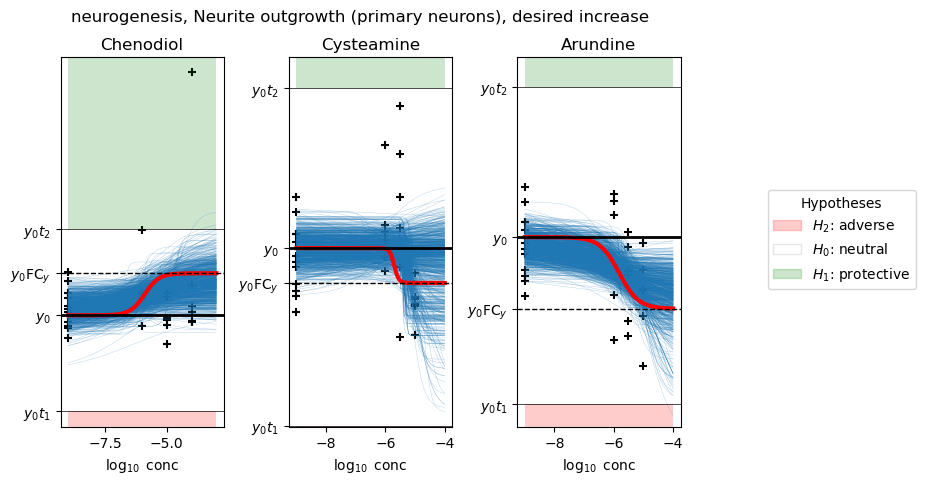

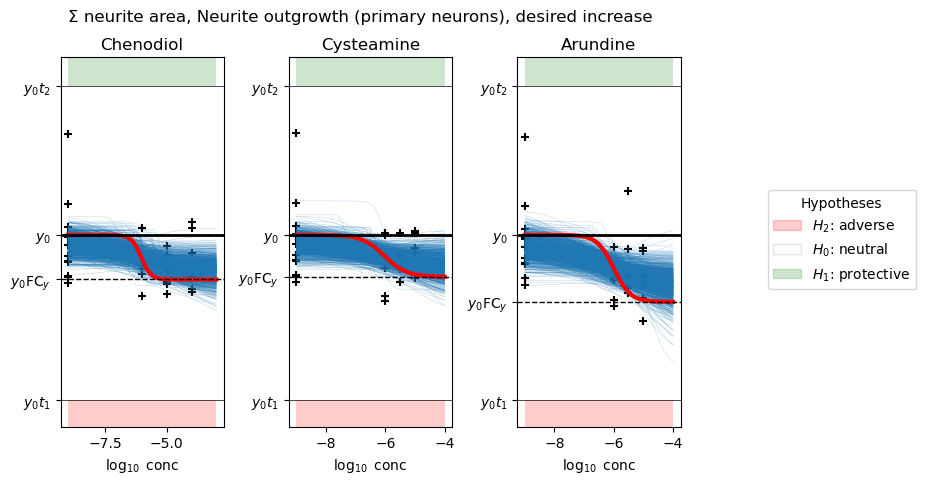

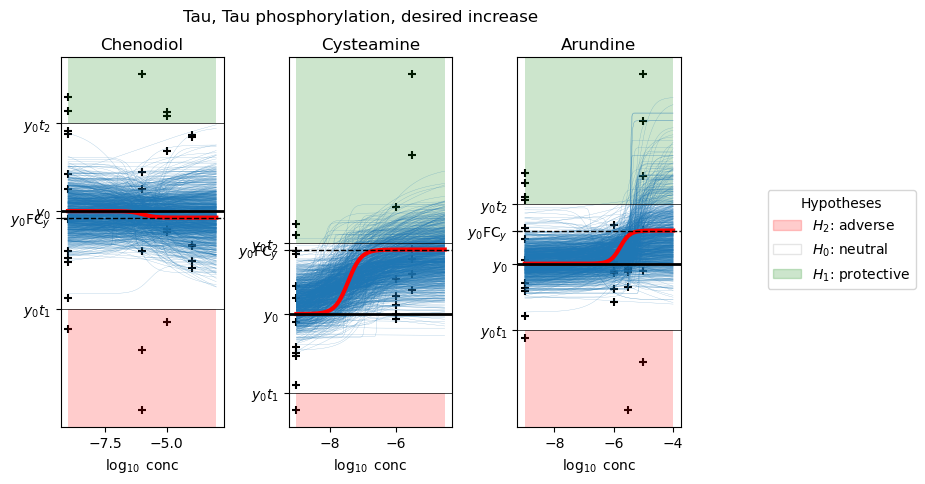

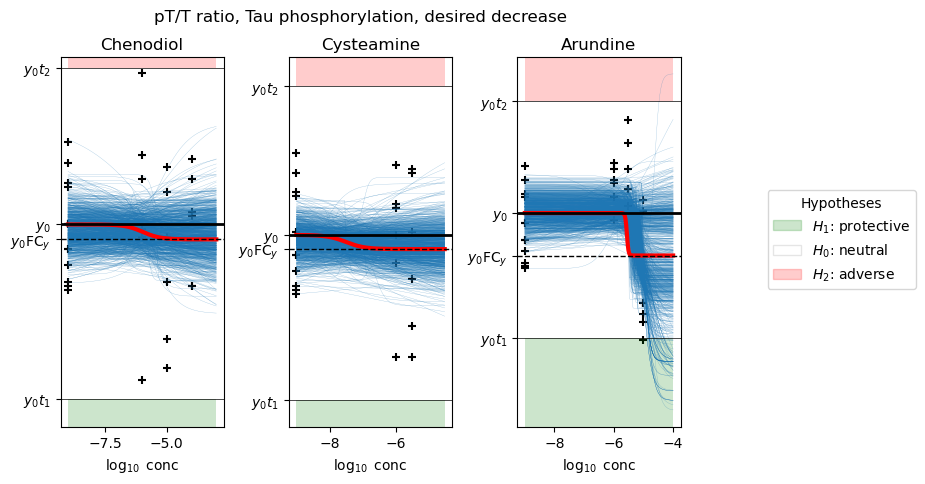

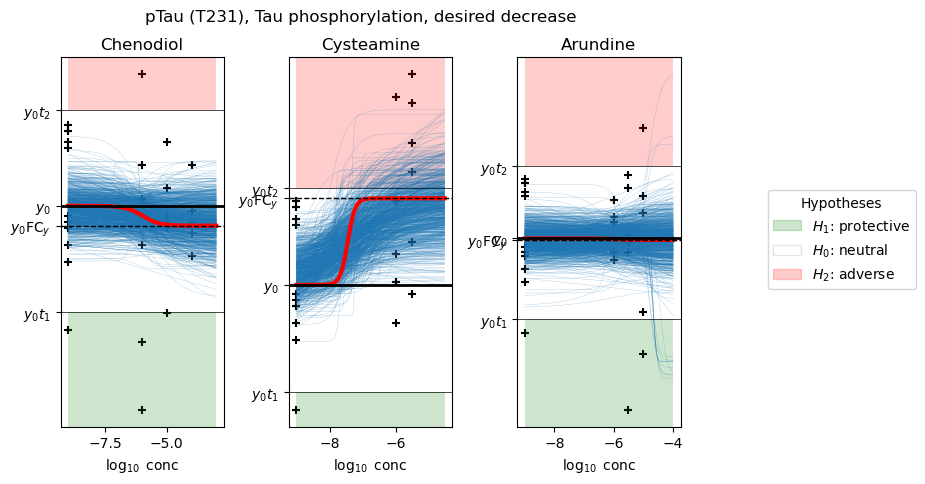

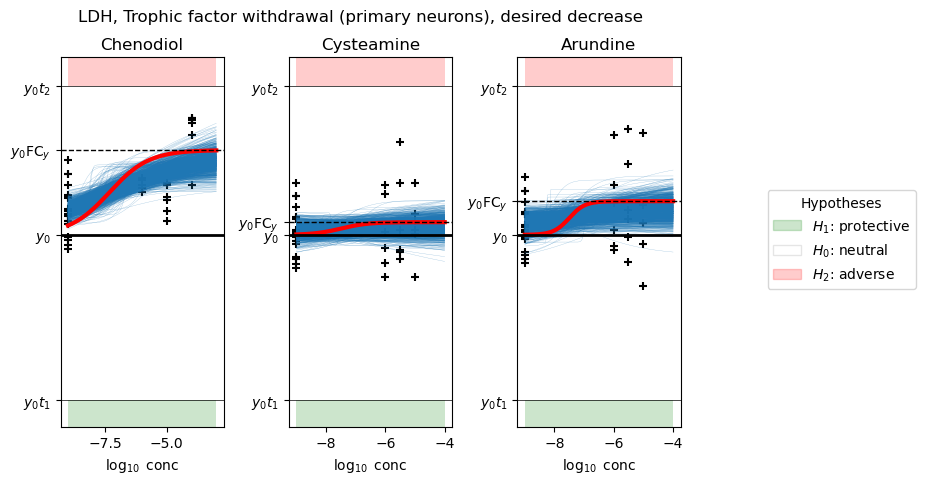

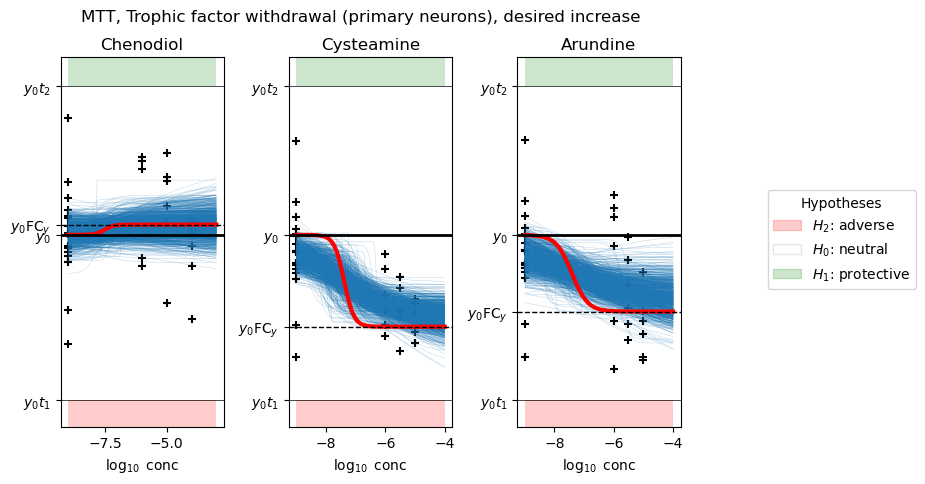

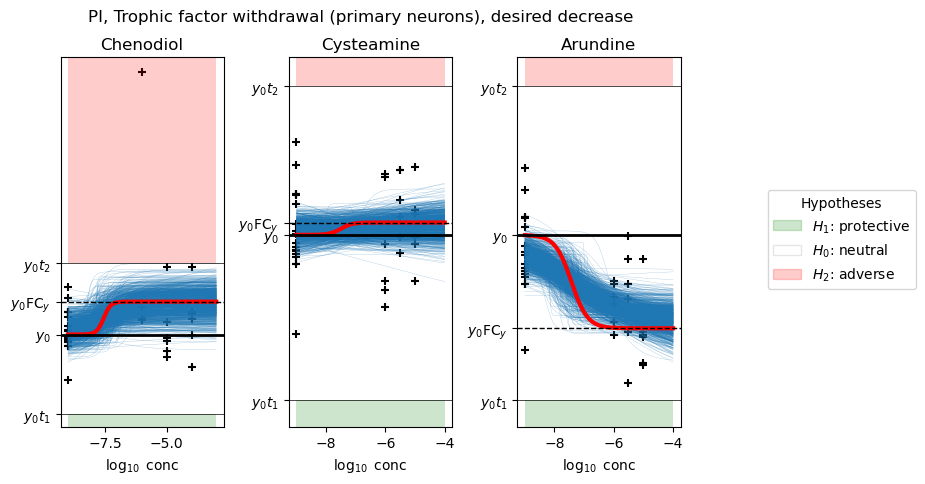

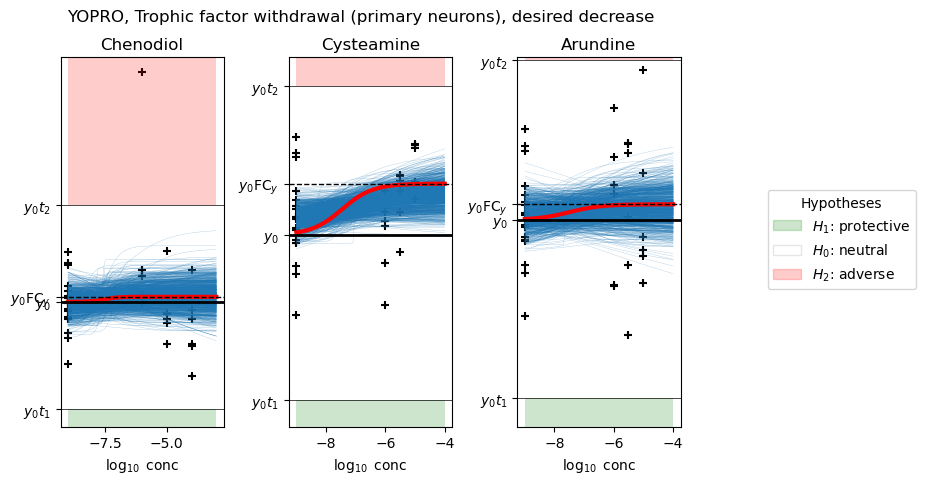

In [50]:
for ix in ideal_H1_increase.sort_values(['experiment (nice)', 'assay (nice)']).index:
    exper, assay = ix
    fname = 'posterior-curves-' + exper + '-' + assay
    fname = fname.replace('/', '-').replace(' ', '-')
    if True:
    #if not os.path.exists('named-figure/' + fname + '.pdf'):
        fig = plot_sampled_curves_all_compounds(exper, assay)
        attila_utils.savefig(fig, fname)

['named-figure/violin-posterior-pdf-legend.png',
 'named-figure/violin-posterior-pdf-legend.pdf']

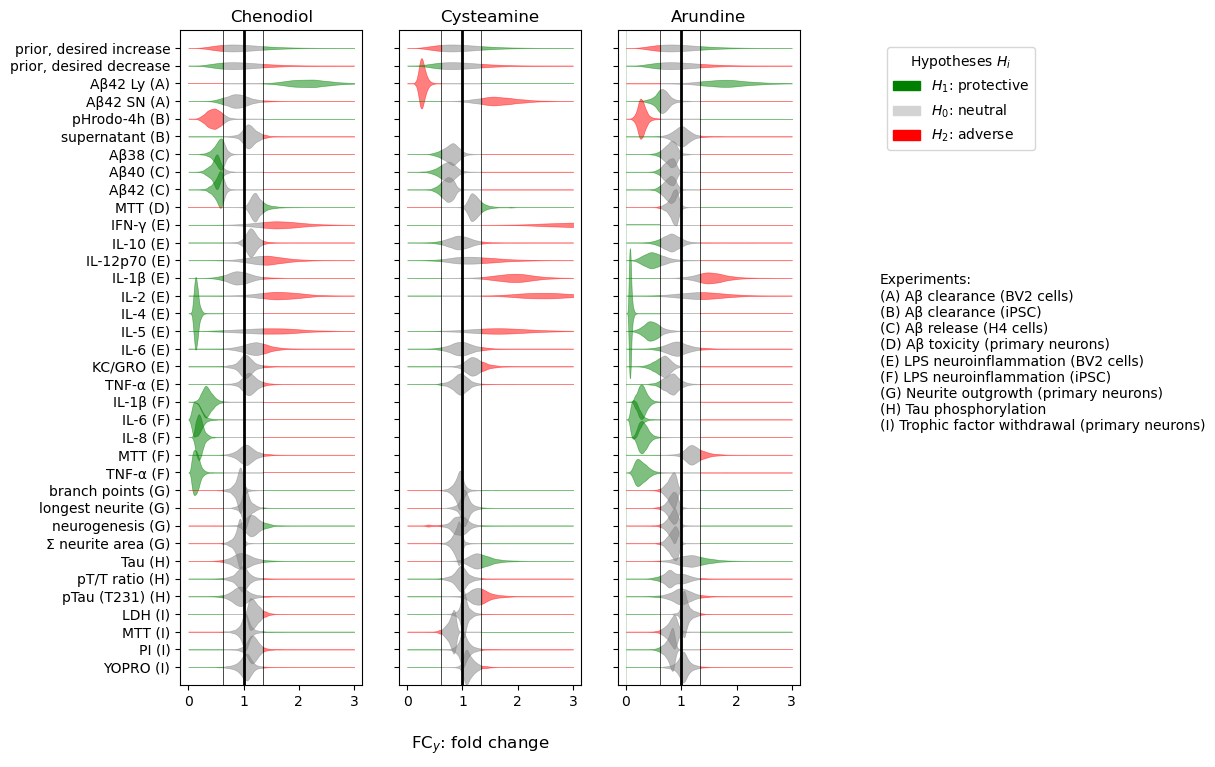

In [51]:
def violin_compound(ax, compound, idatadf, ideal_H1_increase, exper2letter_d):
    FC_y_max=3
    npoints=400
    delta_y = 5

    t_1 = scipy.stats.gamma.ppf(cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    t_2 = scipy.stats.gamma.ppf(1 - cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    xx = np.linspace(0, FC_y_max, npoints)
    yy_prior = scipy.stats.gamma.pdf(xx, cba.gamma_shape, scale=1/cba.gamma_shape)
    b_left = xx <= t_1
    b_right = xx > t_2
    b_center = (~ b_left) & (~ b_right)
    y_bases = np.arange(idatadf.shape[0], step=1) * delta_y
    for t, lw in zip([t_1, t_2, 1], [0.5, 0.5, 2]):
        ax.axvline(t, color='k', linewidth=lw, linestyle='solid')
    df = idatadf.index.to_frame().rename(columns={0: 'experiment', 1:'assay'})
    ticklabels = df.apply(lambda r: r.loc['assay'] + ' (' + exper2letter_d[r.loc['experiment']] + ')', axis=1).to_list()
    ticklabels = ['prior, desired increase', 'prior, desired decrease'] + ticklabels
    yticks_prior = [y_bases.max() + delta_y * 2, y_bases.max() + delta_y]
    yticks = yticks_prior + list(y_bases[::-1])
    ax.set_yticks(yticks)
    ax.set_yticklabels(ticklabels)
    ax.set_ylim(min(yticks) - delta_y, max(yticks) + delta_y)

    def one_violin(ax, exper, assay, y_base):
        H1_increase = ideal_H1_increase.loc[(exper, assay), 'H1_increase']
        if idatadf.loc[(exper, assay), compound] in [None, np.nan]:
            return(None)
        posterior = idatadf.loc[(exper, assay), compound].posterior
        l = list(itertools.chain(*posterior['FC_y'].to_numpy()))
        k = scipy.stats.gaussian_kde(l)
        yy = k.evaluate(xx)
        c_left = 'red' if H1_increase else 'green'
        c_right = 'red' if not H1_increase else 'green'
        c_center = 'gray'
        for b, c in zip([b_left, b_center, b_right], [c_left, c_center, c_right]):
            ax.fill_between(xx[b], y_base + yy[b], y_base - yy[b], alpha=.5, linewidth=0.5, color=c)

    def one_prior_violin(ax, y_base, H1_increase):
        c_left = 'red' if H1_increase else 'green'
        c_right = 'red' if not H1_increase else 'green'
        c_center = 'gray'
        for b, c in zip([b_left, b_center, b_right], [c_left, c_center, c_right]):
            ax.fill_between(xx[b], y_base + yy_prior[b], y_base - yy_prior[b], alpha=.5, linewidth=0.5, color=c)

    for ix, y_base in zip(idatadf.index, y_bases[::-1]):
        one_violin(ax, *ix, y_base)

    for y_base, H1_increase in zip(yticks_prior, [True, False]):
        one_prior_violin(ax, y_base, H1_increase)
        
    return(ax)

def violin_posterior_pdf(idatadf=idatadf, ideal_H1_increase=ideal_H1_increase, text_box=True, H_legend=True):
    df = idatadf.index.to_frame().rename(columns={0: 'experiment', 1:'assay'})
    k = df.experiment.unique()
    v = string.ascii_uppercase[:len(k)]
    exper2letter_d = dict(zip(k, v))
    fig, ax = plt.subplots(1, idatadf.shape[1], figsize=(8, idatadf.shape[0] / 4), sharey=True)
    for axi, compound in zip(ax, idatadf.columns):
        axi.set_title(compound)
        violin_compound(axi, compound, idatadf, ideal_H1_increase, exper2letter_d=exper2letter_d)
    if text_box:
        fig = exper2letter_textbox(fig, exper2letter_d, x=1.0, y=0.5, horizontalalignment='left', verticalalignment='center')
    fig.supxlabel('$\mathrm{FC}_y$: fold change', y=0.025)
    if H_legend:
        bbox_to_anchor = (1, 0.8)
        title = 'Hypotheses $H_i$'
        loc = 'center left'
        colors = ['green', 'lightgray', 'red']
        labels = ['$H_' + str(i) + '$: ' + interpret for i, interpret in zip([1, 0, 2], ['protective', 'neutral', 'adverse'])]
        my_legend(fig, colors=colors, labels=labels, loc=loc, bbox_to_anchor=bbox_to_anchor, title=title, ncols=1)
    return((fig, ax))

fig, ax = violin_posterior_pdf(text_box=True, H_legend=True)
attila_utils.savefig(fig, 'violin-posterior-pdf-legend')

['named-figure/violin-posterior-pdf.png',
 'named-figure/violin-posterior-pdf.pdf']

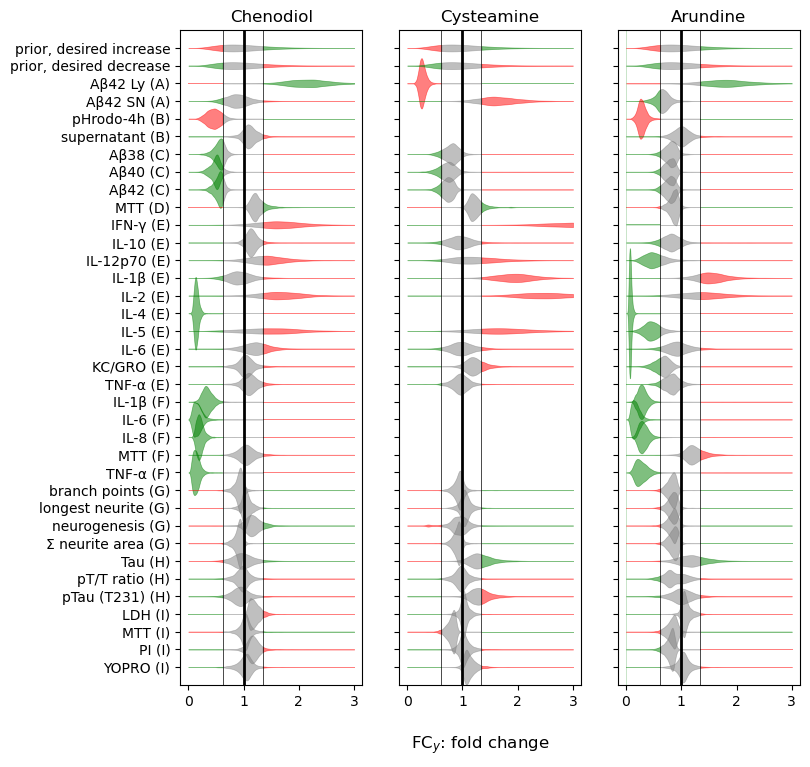

In [52]:
fig, ax = violin_posterior_pdf(text_box=False, H_legend=False)
attila_utils.savefig(fig, 'violin-posterior-pdf')

In [53]:
def get_FC_y_posterior_sample(exper='LPS', assay='IFN-γ', compound='TI21', idatadf=idatadf, ideal_H1_increase=ideal_H1_increase):
    H1_increase = ideal_H1_increase.loc[(exper, assay), 'H1_increase']
    idata = idatadf.loc[(exper, assay), compound]
    if idata in [np.nan, None]:
        idata = idatadf.dropna().iloc[0,0]
        npoints = len(idata.sample_stats['chain']) * len(idata.sample_stats['draw'])
        l = np.repeat(np.nan, npoints)
    else:
        posterior = idata.posterior
        l = list(itertools.chain(*posterior['FC_y'].to_numpy()))
    df = pd.DataFrame({'FC_y': l, 'exper': exper, 'assay': assay, 'compound': compound, 'H1_increase': H1_increase})
    return(df)

def get_FC_y_posterior_sample_all(idatadf=idatadf, ideal_H1_increase=ideal_H1_increase):
    ll = [[get_FC_y_posterior_sample(exper, assay, compound, idatadf) for exper, assay in idatadf.index] for compound in idatadf.columns]
    l = list(itertools.chain(*ll))
    df = pd.concat(l, axis=0)
    return(df)

get_FC_y_posterior_sample_all(idatadf=remove_poorly_fitted(idatadf))

FC_y                                        exper    assay  \
0     1.880653                     Aβ clearance (BV2 cells)  Aβ42 Ly   
1     1.908767                     Aβ clearance (BV2 cells)  Aβ42 Ly   
2     1.711070                     Aβ clearance (BV2 cells)  Aβ42 Ly   
3     1.871327                     Aβ clearance (BV2 cells)  Aβ42 Ly   
4     2.025548                     Aβ clearance (BV2 cells)  Aβ42 Ly   
...        ...                                          ...      ...   
3995  1.076085  Trophic factor withdrawal (primary neurons)    YOPRO   
3996  1.050741  Trophic factor withdrawal (primary neurons)    YOPRO   
3997  0.910565  Trophic factor withdrawal (primary neurons)    YOPRO   
3998  0.939115  Trophic factor withdrawal (primary neurons)    YOPRO   
3999  0.873081  Trophic factor withdrawal (primary neurons)    YOPRO   

       compound  H1_increase  
0     Chenodiol         True  
1     Chenodiol         True  
2     Chenodiol         True  
3     Chenodiol         True  
4     Chenodiol         True  
...         ...          ...  
3995   Arundine        False  
3996   Arundine        False  
3997   Arundine        False  
3998   Arundine        False  
3999   Arundine        False  

[408000 rows x 5 columns]

In [54]:
def violin_color_bg(ax, compound, H1_increase=False, return_data=False,
                    idatadf=idatadf, ideal_H1_increase=ideal_H1_increase, return_exper2letter=False):
    df = get_FC_y_posterior_sample_all(idatadf=remove_poorly_fitted(idatadf), ideal_H1_increase=ideal_H1_increase)
    H1_mask = df.H1_increase if H1_increase else (~ df.H1_increase)
    data = df.loc[H1_mask & (df.compound == compound)]
    k = data.exper.unique()
    v = string.ascii_uppercase[:len(k)]
    exper2letter_d = dict(zip(k, v))
    if return_exper2letter:
        return(exper2letter_d)
    s = data.apply(lambda r: r.loc['assay'] + ' (' + exper2letter_d[r.loc['exper']] + ')', axis=1)
    data = pd.concat([data, s.to_frame('assay (exper)')], axis=1)
    if return_data:
        return(data)
    nassays = np.unique(data.apply(lambda r: r.loc['exper'] + ', ' + r.loc['assay'], axis=1)).shape[0]
    t_H_lo = scipy.stats.gamma.ppf(cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    t_H_up = scipy.stats.gamma.ppf(1 - cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    H0_color = 'gray'
    H1_color = 'green'
    H2_color = 'red'
    color_up = H1_color if H1_increase else H2_color
    color_lo = H2_color if H1_increase else H1_color
    box_alpha=0.25
    ax.add_patch(plt.Rectangle((0, -0.5), width=t_H_lo, height=nassays, color=color_lo, alpha=box_alpha))
    ax.add_patch(plt.Rectangle((t_H_lo, -0.5), width=t_H_up - t_H_lo, height=nassays, color=H0_color, alpha=box_alpha))
    x_right = 2.5
    ax.add_patch(plt.Rectangle((t_H_up, -0.5), width=x_right - t_H_up, height=nassays, color=color_up, alpha=box_alpha))
    ax.axvline(1, color='k', linewidth=1)
    sns.violinplot(data=data, y='assay (exper)', x='FC_y', width=3, ax=ax, inner=None, color='gray', fill=True)
    ax.set_xlim(0, x_right)
    ax.set_ylabel('')
    return(ax)

def violin_color_bg_all(H1_increase=False, idatadf=idatadf, ideal_H1_increase=ideal_H1_increase, text_box=True):
    n_assays = sum(ideal_H1_increase.H1_increase == H1_increase)
    fig, ax = plt.subplots(1, idatadf.shape[1], figsize=(12, n_assays/3), sharey=True)
    for axi, compound in zip(ax, idatadf.columns):
        axi = violin_color_bg(axi, compound, H1_increase=H1_increase)
        exper2letter_d = violin_color_bg(axi, compound, H1_increase=H1_increase, return_exper2letter=True)
        axi.set_title(compound)
    if text_box:
        fig = exper2letter_textbox(fig, exper2letter_d, x=0.0, y=1.0, horizontalalignment='left', verticalalignment='center')
    bbox_to_anchor = (0.5, 1.05)
    title = 'Hypotheses $H_i$'
    loc = 'lower center'
    colors = ['green', 'lightgray', 'red']
    labels = ['$H_' + str(i) + '$: ' + interpret for i, interpret in zip([1, 0, 2], ['protective', 'neutral', 'adverse'])]
    my_legend(fig, colors=colors, labels=labels, loc=loc, bbox_to_anchor=bbox_to_anchor, title=title)
    return(fig)

In [55]:
def exper2letter_textbox(fig, exper2letter_d, x, y, horizontalalignment='left', verticalalignment='center'):
    s = '\n'.join(['(' + v + ') ' + k for k, v in exper2letter_d.items()])
    fig.text(0.0, 1, s, horizontalalignment=horizontalalignment)
    return(fig)

['named-figure/violin-color-bg-ideal-increase.png',
 'named-figure/violin-color-bg-ideal-increase.pdf']

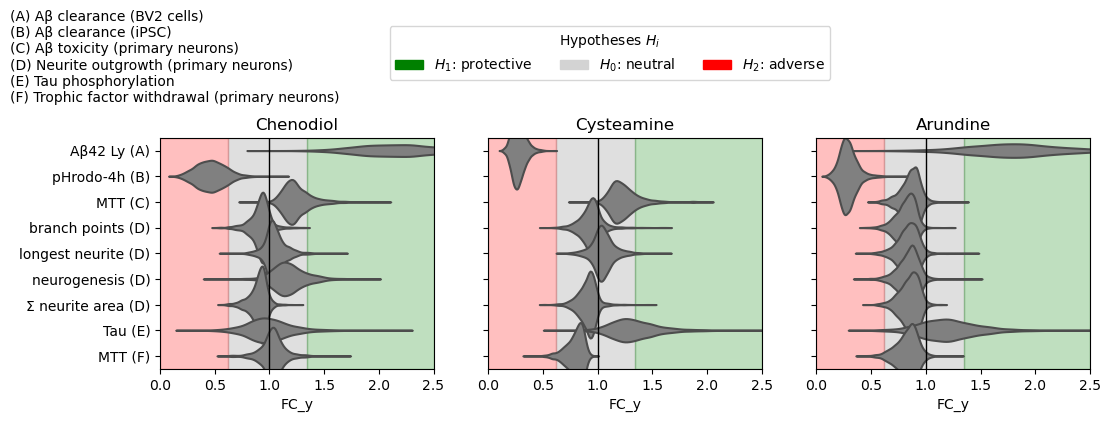

In [56]:
fig = violin_color_bg_all(H1_increase=True, text_box=True)
attila_utils.savefig(fig, 'violin-color-bg-ideal-increase')

['named-figure/violin-color-bg-ideal-decrease.png',
 'named-figure/violin-color-bg-ideal-decrease.pdf']

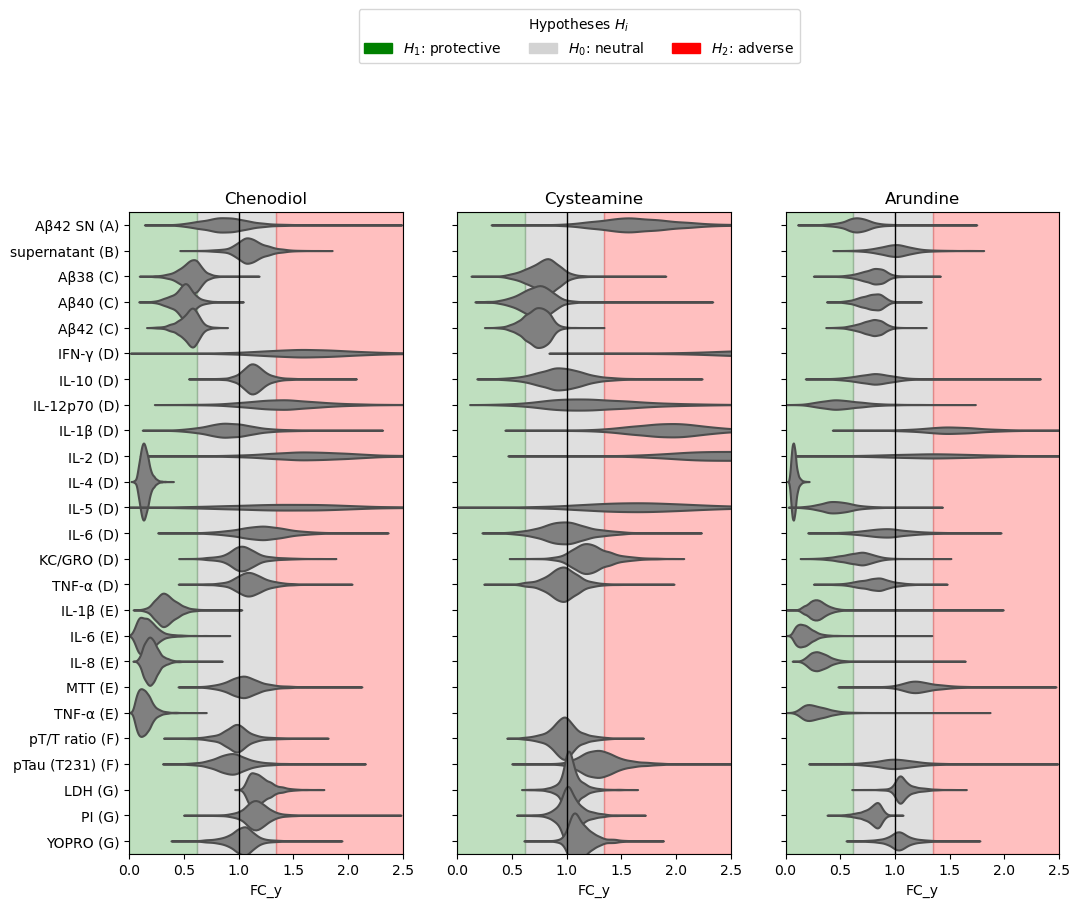

In [57]:
fig = violin_color_bg_all(H1_increase=False, text_box=False)
attila_utils.savefig(fig, 'violin-color-bg-ideal-decrease')

In [71]:
index_col = ['experiment (nice)', 'assay (nice)', 'concentration']
fpath = '../../results/2022-09-21-cell-based-assays/results-protect-pretty.csv'
dunnett = pd.read_csv(fpath, index_col=index_col, usecols=index_col + list(idatadf.columns))#.drop(['class', 'assay', 'conc'], axis=1)
dunnett = dunnett.groupby(level=[0,1], axis=0).mean()
abs_max = dunnett.applymap(abs).max().max()
dunnett.style.format(precision=2).background_gradient(axis=None, vmin=-abs_max, vmax=abs_max, cmap='RdYlGn')

In [72]:
def dunnett_bayes_df(H, dunnett=dunnett, H102_posteriors=H102_posteriors):
    df = pd.concat([dunnett.stack().to_frame('Dunnett'), H102_posteriors.xs(H, axis=1, level=1).stack().to_frame('Bayesian')], axis=1)
    df['i'] = np.arange(df.shape[0])
    return(df)

def dunnett_bayes_scatter_ax(axi, H, name, dunnett=dunnett, H102_posteriors=H102_posteriors, numbered_markers=True, discrepancy_dict=None):
    axi.set_ylabel(r'adverse $\leftarrow$ neutral $\rightarrow$ protective')
    axi.axhline(0, linewidth=0.5, color='gray')
    df = dunnett_bayes_df(H, dunnett=dunnett, H102_posteriors=H102_posteriors)
    df = df.dropna(axis=0)
    if discrepancy_dict is not None:
        dunnett_true = discrepancy_dict[H]['Dunnett true']
        bayes_true = discrepancy_dict[H]['Bayes true']
    if numbered_markers:
        for ix in df.index:
            x, y, i = [df.loc[ix, c] for c in ['Bayesian', 'Dunnett', 'i']]
            if discrepancy_dict is not None:
                color = 'red' if i in dunnett_true else 'k'
                color = 'magenta' if i in bayes_true else color
            else:
                color = 'k'
            axi.text(x=x, y=y, s=str(i), rotation=90, ha='center', va='center', color=color)
            axi.set_xlim(-0.05, 1.05)
    else:
        axi.scatter(y='Dunnett', x='Bayesian', data=df, marker='+')
    ylim = df.Dunnett.apply(abs).max() + 0.2
    axi.set_ylim(-ylim, ylim)
    axi.set_title(H + ': ' + name)
    return(axi)
    

def dunnett_bayes_scatter(dunnett=dunnett, H102_posteriors=H102_posteriors, numbered_markers=True, discrepancy_dict=None):
    hypotheses = H102_posteriors.xs(H102_posteriors.columns[0][0], axis=1, level=0).columns
    hypothesis_names = ['protective', 'neutral', 'adverse']
    fig, ax = plt.subplots(2, 2, sharey=True, figsize=(2 * 4.8, 2* 4.8))
    for axi, H, name in zip(ax.ravel()[:3], hypotheses, hypothesis_names):
        axi = dunnett_bayes_scatter_ax(axi, H, name, dunnett=dunnett, H102_posteriors=H102_posteriors, numbered_markers=numbered_markers, discrepancy_dict=discrepancy_dict)
    fig.supylabel('frequentist score: $-\sum \log_{10}p$', x=0)
    fig.supxlabel('Bayesian score: $P(H_i | \mathrm{data})$', y=0)
    ax.ravel()[-1].remove()
    return((fig, ax))

dunnett_bayes = pd.concat([
    dunnett_bayes_df('H1').rename({'Bayesian': 'H1'}, axis=1)[['i', 'Dunnett', 'H1']],
    dunnett_bayes_df('H0')[['Bayesian']].rename({'Bayesian': 'H0'}, axis=1),
    dunnett_bayes_df('H2')[['Bayesian']].rename({'Bayesian': 'H2'}, axis=1)
], axis=1)
dunnett_bayes.to_clipboard()
dunnett_bayes

i   Dunnett       H1  \
Aβ clearance (BV2 cells)     Aβ42 Ly Chenodiol    0  0.666667  0.99275   
                                     Cysteamine   1 -0.666667  0.00000   
                                     Arundine     2  0.333333  0.87900   
                             Aβ42 SN Chenodiol    3  0.000000  0.09825   
                                     Cysteamine   4 -0.333333  0.00200   
...                                              ..       ...      ...   
LPS neuroinflammation (iPSC) MTT     Chenodiol   94       NaN  0.00275   
                             TNF-α   Chenodiol   95       NaN  0.99975   
Tau phosphorylation          Tau     Chenodiol   96       NaN  0.05300   
                                     Cysteamine  97       NaN  0.41825   
                                     Arundine    98       NaN  0.27375   

                                                      H0       H2  
Aβ clearance (BV2 cells)     Aβ42 Ly Chenodiol   0.00725  0.00000  
                                     Cysteamine  0.00000  1.00000  
                                     Arundine    0.12000  0.00100  
                             Aβ42 SN Chenodiol   0.86375  0.03800  
                                     Cysteamine  0.18175  0.81625  
...                                                  ...      ...  
LPS neuroinflammation (iPSC) MTT     Chenodiol   0.94775  0.04950  
                             TNF-α   Chenodiol   0.00025  0.00000  
Tau phosphorylation          Tau     Chenodiol   0.91800  0.02900  
                                     Cysteamine  0.58150  0.00025  
                                     Arundine    0.71625  0.01000  

[99 rows x 5 columns]

['named-figure/dunnett-bayes-scatter.png',
 'named-figure/dunnett-bayes-scatter.pdf']

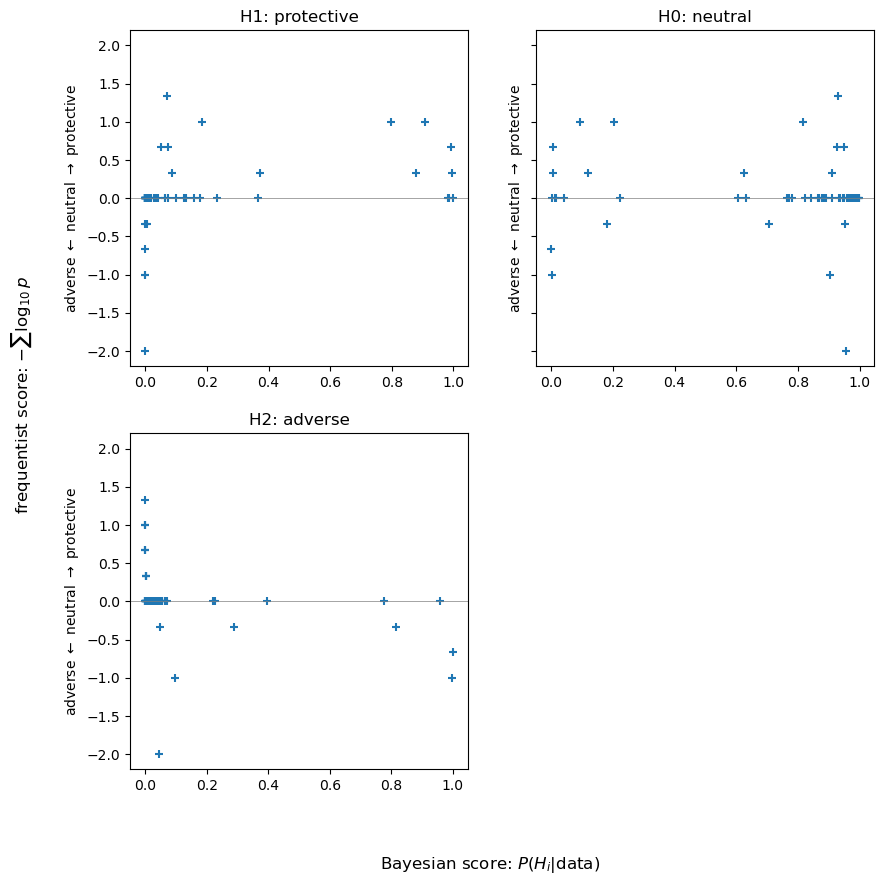

In [73]:
fig, ax = dunnett_bayes_scatter(dunnett=dunnett, H102_posteriors=H102_posteriors, numbered_markers=False)
attila_utils.savefig(fig, 'dunnett-bayes-scatter')

['named-figure/dunnett-bayes-scatter-numbered.png',
 'named-figure/dunnett-bayes-scatter-numbered.pdf']

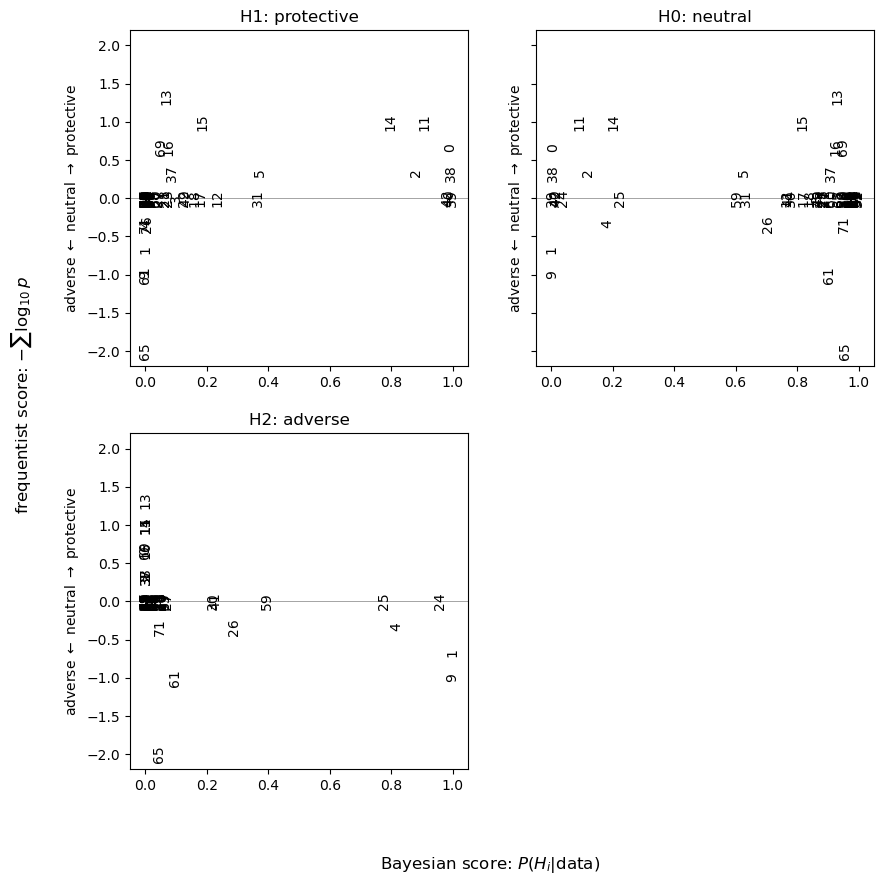

In [74]:
fig, ax = dunnett_bayes_scatter(dunnett=dunnett, H102_posteriors=H102_posteriors)
attila_utils.savefig(fig, 'dunnett-bayes-scatter-numbered')

['named-figure/dunnett-bayes-scatter-numbered-color.png',
 'named-figure/dunnett-bayes-scatter-numbered-color.pdf']

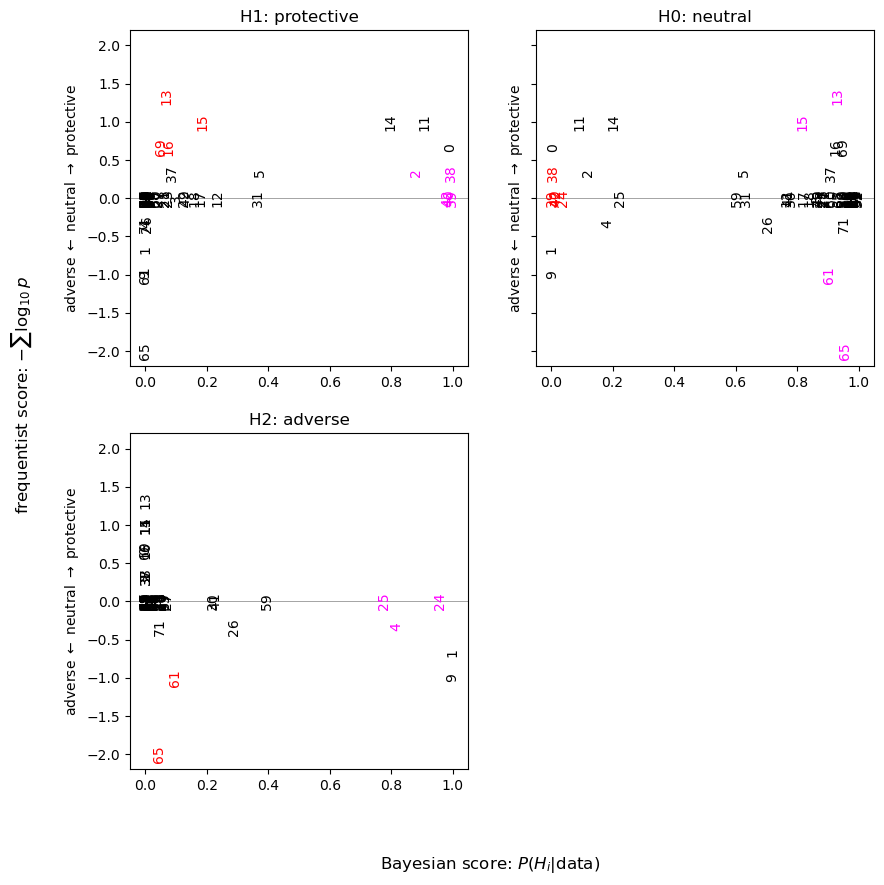

In [75]:
discrepancy_dict = {
    'H1': {'Dunnett true': [13, 15, 69, 16], 'Bayes true': [42, 40, 39, 38, 2]},
    'H0': {'Dunnett true': [39, 40, 42, 38, 24], 'Bayes true': [65, 61, 13, 15]},
    'H2': {'Dunnett true': [65, 61], 'Bayes true': [24, 25, 4]},
}
fig, ax = dunnett_bayes_scatter(dunnett=dunnett, H102_posteriors=H102_posteriors, discrepancy_dict=discrepancy_dict)
attila_utils.savefig(fig, 'dunnett-bayes-scatter-numbered-color')

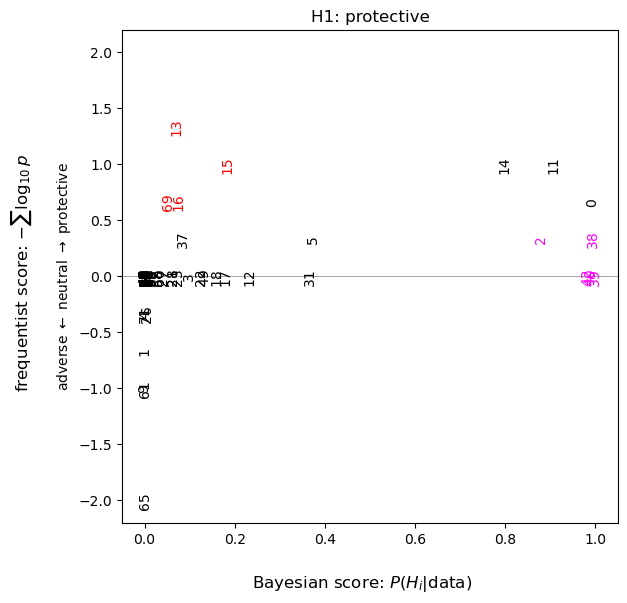

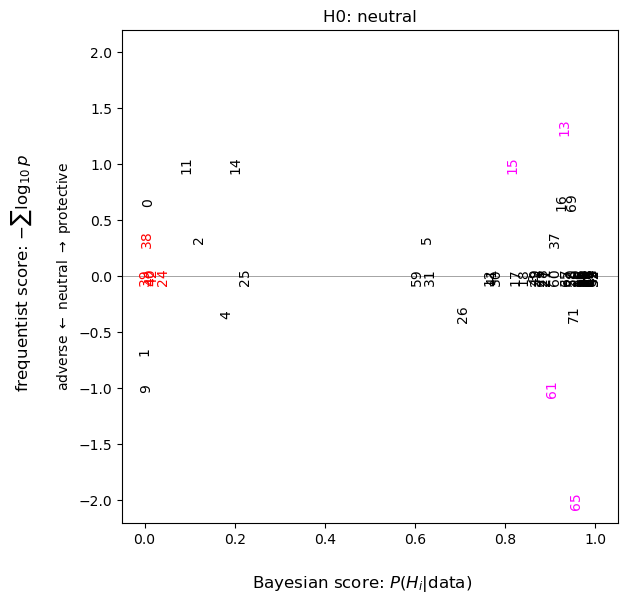

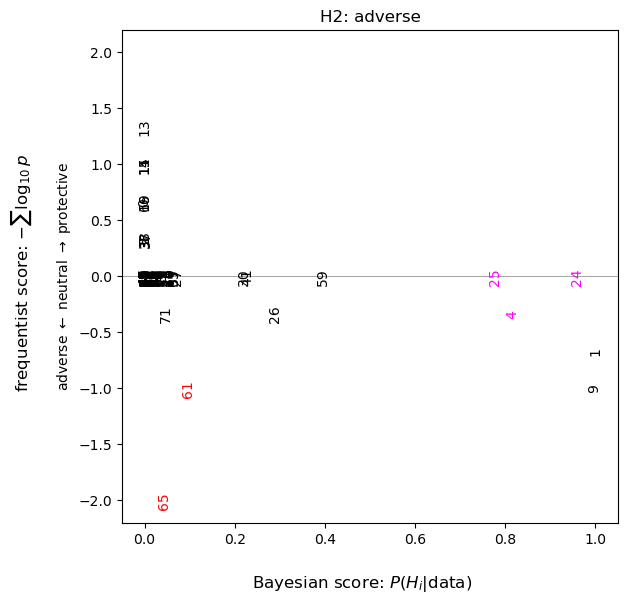

In [76]:
for H, name in zip(['H1', 'H0', 'H2'], ['protective', 'neutral', 'adverse']):
    fig, axi = plt.subplots(figsize=(6.4, 6.4))
    axi = dunnett_bayes_scatter_ax(axi, H, name, discrepancy_dict=discrepancy_dict)
    fig.supylabel('frequentist score: $-\sum \log_{10}p$', x=-0.05)
    fig.supxlabel('Bayesian score: $P(H_i | \mathrm{data})$', y=0)
    attila_utils.savefig(fig, 'dunnett-bayes-scatter-numbered-color-' + H)

In [77]:
def plot_sampled_curves_dunnett_bayes(hypothesis='H1', which_true='Dunnett true', dunnett_bayes=dunnett_bayes, discrepancy_dict=discrepancy_dict):
    df = dunnett_bayes.iloc[discrepancy_dict[hypothesis][which_true]]
    fig, ax = plt.subplots(2, np.int64(np.ceil(df.shape[0] / 2)), figsize=(1.5 * df.shape[0], 6.4))
    for k, axi in enumerate(ax.ravel()[:df.shape[0]]):
        exper, assay, compound = df.index[k]
        i = str(df.loc[df.index[k], 'i'])
        axi = plot_sampled_curves_one_compound(axi, compound, exper=exper, assay=assay, plot_sampled_curves=True)
        axi.set_title('label = ' + '\n'.join([i, compound, assay, exper[:25]]), fontsize=10)
        axi.set_xlabel('')
    fig.subplots_adjust(wspace=0.4, hspace=0.6)
    technique = 'Bayesian' if which_true == 'Bayesian true' else 'Frequentist'
    fig.suptitle('Hypothesis ' + hypothesis + ' is true only under the ' + technique + ' test', y=1.05)
    fig.supxlabel('$-\log_{10}$ conc')
    fig.supylabel('activity')
    return((fig, ax))
    
#fig, ax = plot_sampled_curves_dunnett_bayes(hypothesis='H1', which_true='Dunnett true')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:250: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

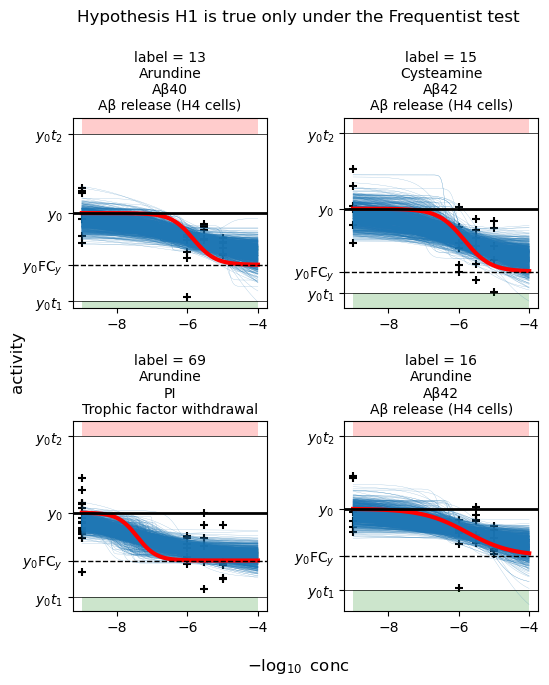

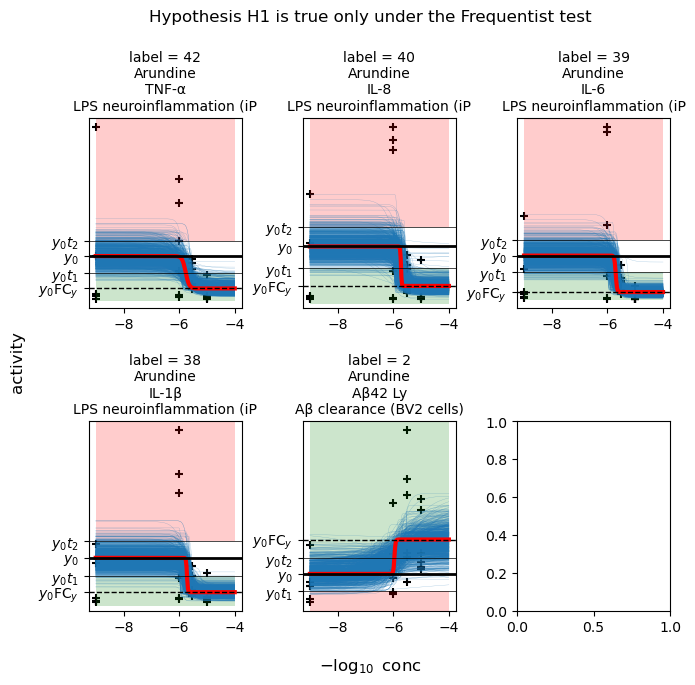

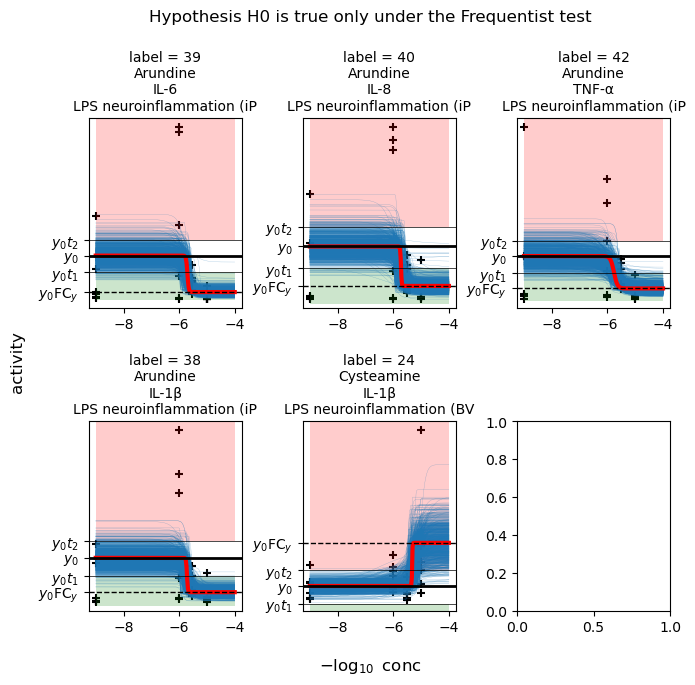

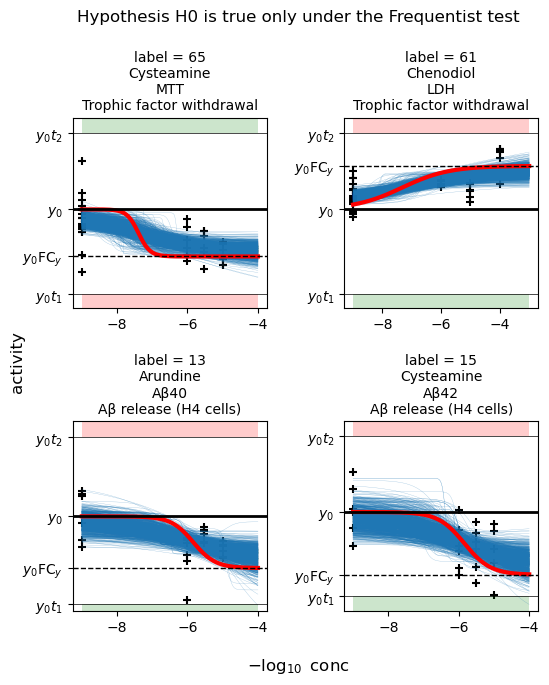

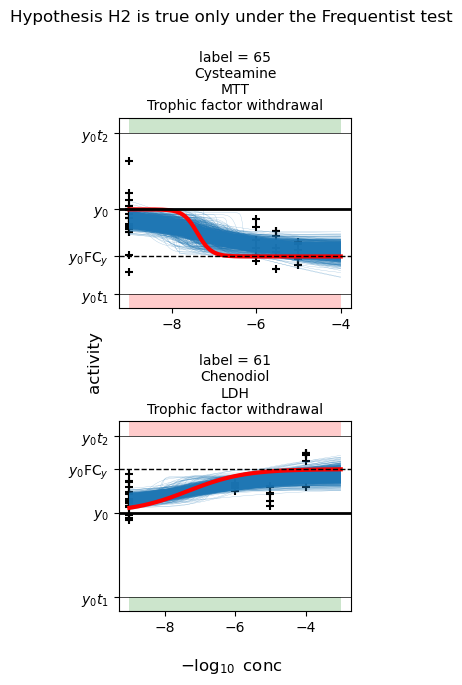

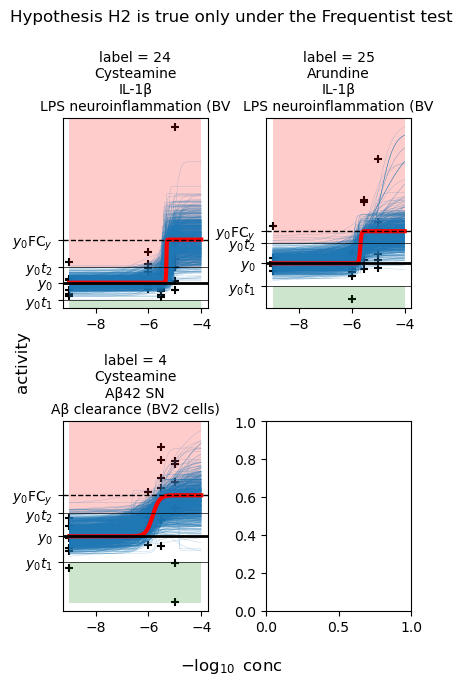

In [78]:
for H, d in discrepancy_dict.items():
    for which_true in d.keys():
        fig, ax = plot_sampled_curves_dunnett_bayes(hypothesis=H, which_true=which_true)
        attila_utils.savefig(fig, 'dunnett-bayes-curves-' + H + '-' + which_true.replace(' ', '-'))

In [79]:
%connect_info

{
  "shell_port": 52345,
  "iopub_port": 52346,
  "stdin_port": 52347,
  "control_port": 52349,
  "hb_port": 52348,
  "ip": "127.0.0.1",
  "key": "782d7f90-62bf1b21a39d690bb3fd2992",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6ccbbabb-c940-4248-80fb-02d85c6047ed.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
